In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import datetime
from WindPy import w
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [2]:
def stock_data(stockList, factor, startDate, endDate):
    data = w.wsd(stockList, factor, startDate, endDate, "")
    df = pd.DataFrame(data.Data, columns = data.Times, index = stockList).T
    return df

In [3]:
def weight_stock(m, ratio, weights):
    N_sect = 10
    bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
    bins.append(ratio)
    bins.sort()
    index = bins.index(ratio)
    return np.around(weights[index],decimals =2)

In [4]:
def updateMoney(t,t_lasttime,weights,money,stockClose,merged_data):
    dailyReturnOfBond = merged_data.loc[t_lasttime: t]['bond10y'].mean()/365
    bondIncome = (t-t_lasttime).days * dailyReturnOfBond * (1-weights) * money
    stockIncome = (stockClose[t]-stockClose[t_lasttime])/stockClose[t_lasttime] * weights * money
    money += (stockIncome + bondIncome)
    return money

In [5]:
def weight_stock_comprehensive(returnRatio_temp, t, weights):
    returnRatio_temp_t = returnRatio_temp[:t]
    N_sect = 10
    i_best = returnRatio_temp_t.columns[0]
    index_best = -1
    for i in returnRatio_temp_t:
        m = returnRatio_temp_t[i]
        bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
        bins.append(returnRatio_temp_t.loc[t][i])
        bins.sort()
        index = bins.index(returnRatio_temp_t.loc[t][i])
        if index > index_best:
            i_best = i
            index_best = index
    return [i_best,np.around(weights[index_best],decimals =2)]

In [6]:
stockList = ["000300.SH","000905.SH","399006.SZ","881001.WI"]
startDate = "20090101"
endDate = "20210101"
N = 1 # N-month return of index

stockPEdf = stock_data(stockList, "pe_ttm", startDate, endDate)
bond10y = w.edb("M1001654", startDate, endDate)
bonddf = pd.DataFrame(bond10y.Data,columns = bond10y.Times, index = ["bond10y"]).T/100
merged_data = pd.concat([1/stockPEdf,bonddf],axis = 1,join = 'inner')

returnRatio = pd.DataFrame(index = stockList,columns = merged_data.index).T
for i in stockList:
    returnRatio[i] = merged_data[i].T / merged_data[merged_data.columns[-1]].T
returnRatio = np.around(returnRatio, decimals = 2, out = None)

stockClosedf = stock_data(stockList, 'CLOSE', startDate, endDate)

In [41]:
pd.set_option('display.max_rows', None)
# returnRatio

## 四种指数（沪深300、中证500、创业板、万得全A）股债比

<AxesSubplot:>

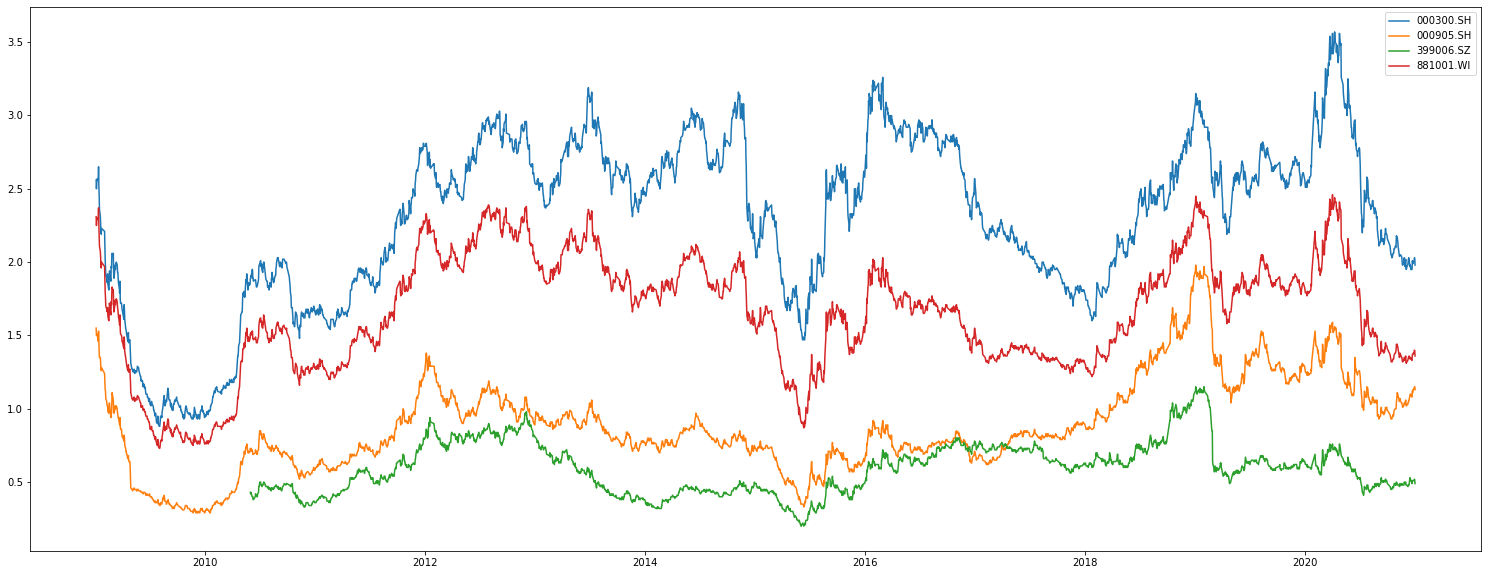

In [8]:
returnRatio.plot(figsize=(26,10))

In [9]:
def return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data):
    m = returnRatio[returnRatio.columns[stock_num]]
    stockClose = stockClosedf[stockClosedf.columns[stock_num]]
    weights_assigned = [i for i in np.arange(0,1,0.1)]

    t = t_lasttime = testStartDate
    weights_new = weights_lasttime = weight_stock(m[:t],m[t],weights_assigned)
    money = 1

    time_all = []
    money_all = []
    index_all = []
    position_all = []
    time_all.append(t)
    money_all.append(money)
    index_all.append(stockClose[t])
    position_all.append(weights_new)

    testStart_indexNum = m.index.tolist().index(testStartDate)
    for i in range(testStart_indexNum+1,len(m)):   
        if i%21 == 0:
            weights_new = weight_stock(m[:(i+1)],m[i],weights_assigned)
            t = m.index[i]
            money = updateMoney(t,t_lasttime, weights_lasttime,money,stockClose,merged_data)
            weights_lasttime = weights_new
            t_lasttime = t

            time_all.append(t)
            money_all.append(money)
            index_all.append(stockClose[t])
            position_all.append(weights_new)

    startYear = str(testStartDate).split("-")[0]
    if startYear == '2014':
        denominator = 7
    elif startYear == '2015':
        denominator = 6
    elif startYear == '2016':
        denominator = 5
    elif startYear == '2017':
        denominator = 4
    print(m.name)
    print("训练开始日期("+str(stockClose.index[0])+")："+str(stockClose[0]) + "   测试开始日期("+str(testStartDate)+")："+str(stockClose[testStart_indexNum]) +"    结束日期("+str(stockClose.index[-1])+")："+str(stockClose[-1]))
    print("指数总收益率： " + str(stockClose[-1]/stockClose[testStart_indexNum] - 1) + "   指数年化收益率： " + str((stockClose[-1]/stockClose[testStart_indexNum])**(1/denominator) - 1))
    print("策略总收益率： " + str(money - 1) + "   策略年化收益率： " + str(money**(1/denominator) - 1))
    print()
    return[time_all,money_all,position_all]

# 仅含万得全A策略 (资金投入日期：2014年初）

In [67]:
stock_num = -1
testStartDate  = datetime.date.fromisoformat('2014-01-02')
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

881001.WI
训练开始日期(2009-01-05)：1486.1136   测试开始日期(2014-01-02)：2344.197    结束日期(2020-12-31)：5422.197
指数总收益率： 1.3130295789986932   指数年化收益率： 0.12726463873867444
策略总收益率： 1.5065962618182356   策略年化收益率： 0.14028143966557227



## 指数历史走势

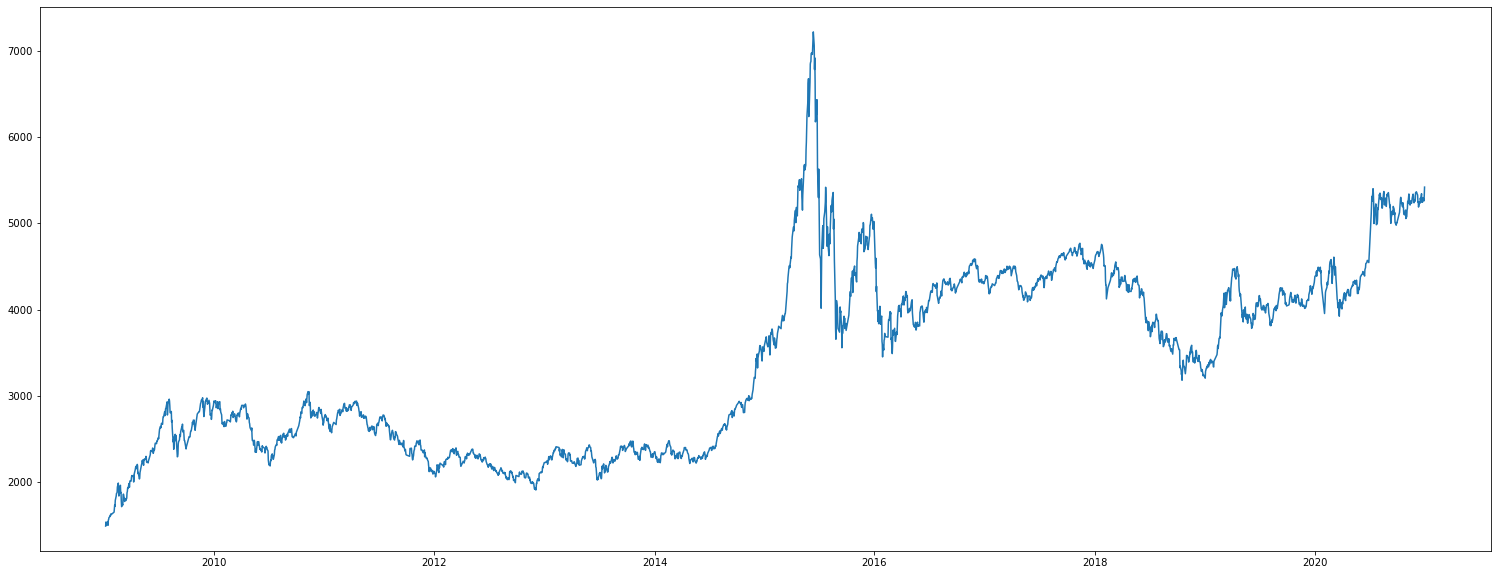

In [68]:
plt.figure(figsize=(26,10))
plt.plot(stockClosedf[stockClosedf.columns[stock_num]])

## 策略资金变化和股票仓位比关系

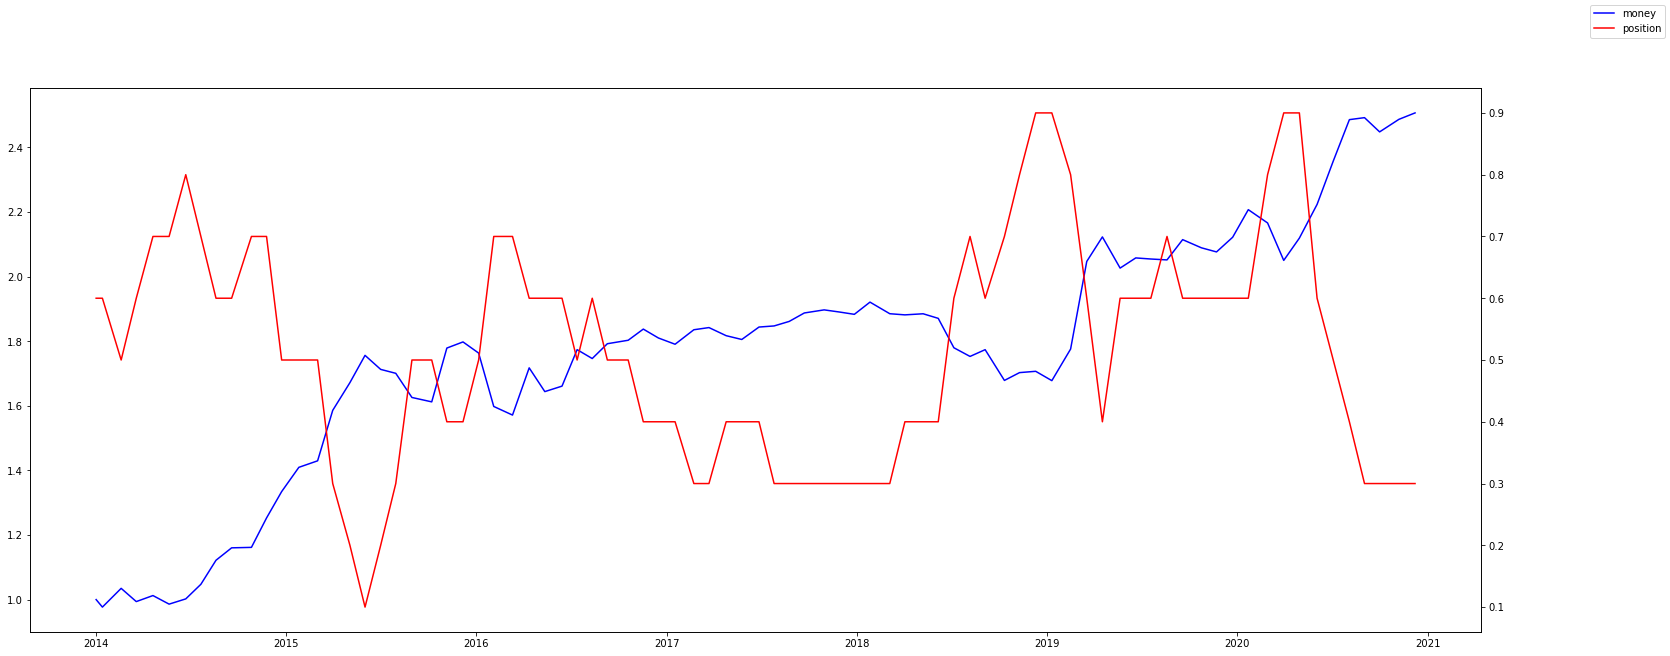

In [69]:
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,money_all,color = 'blue',label = 'money')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(150))
# ax1.grid()
ax2 = ax1.twinx() 
ax2.plot(time_all,position_all,color = 'red',label = 'position')
fig.legend()

## 收益率变化情况

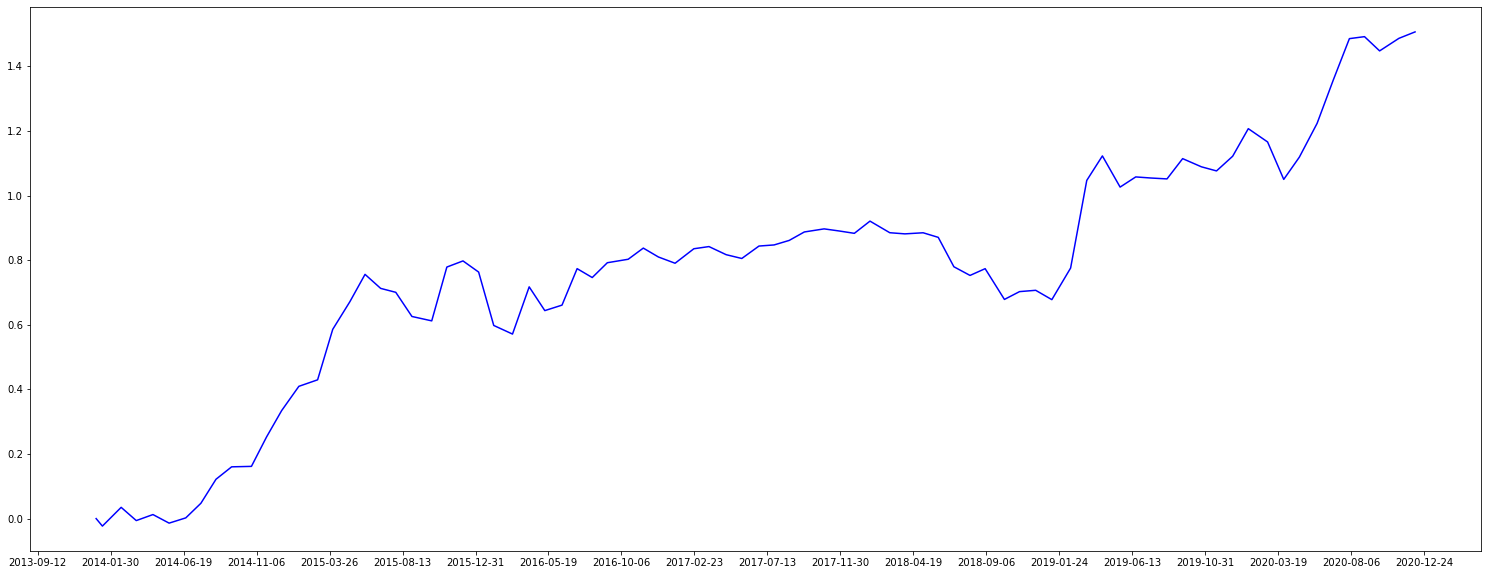

In [70]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,[i-1 for i in money_all],color = 'blue')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(140))
# ax1.grid()
# ax2 = ax1.twinx() 
# ax1.plot(time_all,[i-1 for i in money_all/money_all[0]],color = 'red')

## 策略最大回撤

In [71]:
max_drawdown = 0
max_drawdown_start = 0
max_drawdown_end = 0
for i in range(len(money_all)):
    for j in range(i+1,len(money_all)):
        if (money_all[i]-money_all[j])>max_drawdown:
            max_drawdown_start = i
            max_drawdown_end = j
            max_drawdown = money_all[i]-money_all[j]
print("策略最大回撤："+str(max_drawdown/money_all[max_drawdown_start])+"   时间："+str(time_all[max_drawdown_start]) + "("+str(np.around(money_all[max_drawdown_start],decimals =3))
      +") 至 "+str(time_all[max_drawdown_end])+ "("+str(np.around(money_all[max_drawdown_end],decimals =3))+")")

策略最大回撤：0.12654328482823018   时间：2018-01-26(1.921) 至 2019-01-10(1.678)


In [72]:
stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

资金   仓位     策略收益率  881001.WI     指数收益率
2014-01-02         1  0.6  0.000000  2350.4008  0.000000
2014-01-14  0.976782  0.6 -0.023491  2257.0748 -0.040516
2014-02-19  1.034801  0.5  0.057701  2473.8054  0.091688
2014-03-20  0.993832  0.6 -0.040396  2269.1380 -0.086358
2014-04-21  1.012478  0.7  0.018588  2334.1639  0.028254
2014-05-22  0.985952  0.7 -0.026549  2243.1566 -0.039770
2014-06-23  1.002194  0.8  0.016340  2292.4915  0.021755
2014-07-22  1.047385  0.7  0.044104  2419.8240  0.054056
2014-08-20  1.121768  0.6  0.068610  2661.8176  0.095314
2014-09-19  1.160216  0.6  0.033700  2807.6867  0.053352
2014-10-27  1.161643  0.7  0.001229  2805.8149 -0.000667
2014-11-25  1.252698  0.7  0.075464  3116.5342  0.105028
2014-12-24  1.334346  0.5  0.063142  3402.8249  0.087884
2015-01-26  1.409429  0.5  0.054743  3774.7591  0.103731
2015-03-03  1.429587  0.5  0.014201  3870.0943  0.024942
2015-04-01  1.585834  0.3  0.103725  4705.2927  0.195409
2015-05-04  1.671652  0.2  0.052702  5519.1104  0.159529
2015-06-02  1.756034  0.1  0.049246  6851.7341  0.216285
2015-07-02  1.712616  0.2 -0.025036  4975.3161 -0.320013
2015-07-31  1.700462  0.3 -0.007122  4743.5066 -0.047712
2015-08-31  1.625684  0.5 -0.044971  4015.5468 -0.166603
2015-10-08  1.612088  0.5 -0.008398  3934.5299 -0.020382
2015-11-06  1.778647  0.4  0.098322  4737.9198  0.185807
2015-12-07  1.797645  0.4  0.010624  4845.6710  0.022488
2016-01-06  1.763134  0.5 -0.019385  4595.6297 -0.052980
2016-02-04  1.597876  0.7 -0.098417  3723.8562 -0.210346
2016-03-11  1.571226  0.7 -0.016819  3630.6290 -0.025354
2016-04-12  1.717314  0.6  0.088905  4108.9729  0.123767
2016-05-12   1.64385  0.6 -0.043721  3809.4648 -0.075684
2016-06-14  1.660799  0.6  0.010258  3868.1333  0.015283
2016-07-13   1.77374  0.5  0.065792  4300.6545  0.105995
2016-08-11  1.746226  0.6 -0.015633  4157.7337 -0.033797
2016-09-09  1.792073  0.5  0.025916  4333.6867  0.041448
2016-10-19  1.802806  0.5  0.005971  4372.6182  0.008943
2016-11-17  1.837356  0.4  0.018983  4530.6667  0.035507
2016-12-16  1.809836  0.4 -0.015091  4344.7809 -0.041894
2017-01-17   1.79046  0.4 -0.010764  4210.2410 -0.031455
2017-02-22  1.835334  0.3  0.024754  4453.1565  0.056093
2017-03-23  1.842057  0.3  0.003656  4479.9412  0.005997
2017-04-25  1.816971  0.4 -0.013712  4244.9811 -0.053873
2017-05-25  1.805218  0.4 -0.006490  4157.5835 -0.020803
2017-06-27    1.8437  0.4  0.021093  4358.9623  0.047300
2017-07-26  1.847131  0.3  0.001859  4360.6756  0.000393
2017-08-24  1.861142  0.3  0.007556  4441.6692  0.018403
2017-09-22  1.887279  0.3  0.013946  4619.7341  0.039307
2017-10-30  1.896842  0.3  0.005054  4656.2490  0.007873
2017-11-28   1.89032  0.3 -0.003444  4569.0251 -0.018910
2017-12-27  1.883067  0.3 -0.003845  4477.5067 -0.020234
2018-01-26  1.920863  0.3  0.019873  4743.2999  0.057667
2018-03-05  1.884951  0.3 -0.018873  4403.0184 -0.074443
2018-04-03  1.881404  0.4 -0.001883  4344.4897 -0.013382
2018-05-08  1.884783  0.4  0.001794  4341.2048 -0.000756
2018-06-06  1.870593  0.4 -0.007557  4240.5291 -0.023464
2018-07-06  1.779602  0.6 -0.049866  3706.1205 -0.134702
2018-08-06  1.752748  0.7 -0.015205  3605.5606 -0.027508
2018-09-04  1.773676  0.6  0.011869  3662.6577  0.015712
2018-10-11  1.678445  0.7 -0.055187  3325.8950 -0.096450
2018-11-09  1.702635  0.8  0.014309  3390.3621  0.019198
2018-12-10  1.706697  0.9  0.002383  3398.0427  0.002263
2019-01-10  1.677791  0.9 -0.017082  3333.0501 -0.019312
2019-02-15  1.775578  0.8  0.056648  3547.7599  0.062429
2019-03-18  2.046853  0.6  0.142178  4222.9233  0.174211
2019-04-17  2.122711  0.4  0.036391  4476.3576  0.058282
2019-05-21  2.026215  0.6 -0.046525  3946.6978 -0.125930
2019-06-20  2.057686  0.6  0.015413  4041.8110  0.023814
2019-07-19  2.054312  0.6 -0.001641  4023.9310 -0.004434
2019-08-19  2.051537  0.7 -0.001352  4007.8211 -0.004012
2019-09-18  2.114307  0.6  0.030138  4178.6862  0.041749
2019-10-24  2.089011  0.6 -0.012037  4086.6986 -0.022259
2019-11-22   2.07626  0.6 -0

## 策略表现
### 年化波动率计算：标准差*(N^0.5)

In [91]:
time_temp = ['2014年','2015年','2016年','2017年','2018年','2019年','2020年','七年总计'] 
return_temp = [money_all[12]/money_all[0]-1,money_all[23]/money_all[12]-1,money_all[35]/money_all[23]-1,money_all[47]/money_all[35]-1,
               money_all[58]/money_all[47]-1,money_all[70]/money_all[58]-1, money_all[-1]/money_all[70]-1,money_all[-1]/money_all[0]-1]
money_temp = [money_all[12],money_all[23],money_all[35],money_all[47], money_all[58], money_all[70],money_all[-1],money_all[-1]]
return_volatility = [info.iloc[:13].std()[2]*(13**0.5),info.iloc[13:24].std()[2]*(11**0.5),info.iloc[24:36].std()[2]*(12**0.5),
                     info.iloc[36:48].std()[2]*(12**0.5),info.iloc[48:59].std()[2]*(11**0.5),info.iloc[59:71].std()[2]*(12**0.5),info.iloc[71:].std()[2]*(11**0.5)]
return_volatility.append(sum([i/len(return_volatility) for i in return_volatility]))
sharpe_ratio_strategy = [(return_temp[0] - bonddf.loc[time_all[0]:time_all[12]].mean()[0])/info.iloc[:13].std()[2],(return_temp[1] - bonddf.loc[time_all[12]:time_all[23]].mean()[0])/info.iloc[13:24].std()[2],
                        (return_temp[2] - bonddf.loc[time_all[23]:time_all[35]].mean()[0])/info.iloc[24:36].std()[2],(return_temp[3] - bonddf.loc[time_all[35]:time_all[47]].mean()[0])/info.iloc[36:48].std()[2],
                         (return_temp[4] - bonddf.loc[time_all[47]:time_all[58]].mean()[0])/info.iloc[48:59].std()[2],(return_temp[5] - bonddf.loc[time_all[59]:time_all[71]].mean()[0])/info.iloc[:13].std()[2],
                         (return_temp[6] - bonddf.loc[time_all[70]:time_all[-1]].mean()[0])/info.iloc[71:].std()[2], (return_temp[7] - bonddf.loc[time_all[0]:time_all[-1]].mean()[0])/info.std()[2]]

index_temp = [stockClose.loc[info.index[12]],stockClose.loc[info.index[23]],stockClose.loc[info.index[35]],stockClose.loc[info.index[47]],
              stockClose.loc[info.index[58]],stockClose.loc[info.index[70]],stockClose.loc[info.index[-1]],stockClose.loc[info.index[-1]]]
index_return = [stockClose.loc[info.index[12]]/stockClose.loc[info.index[0]]-1,stockClose.loc[info.index[23]]/stockClose.loc[info.index[12]]-1,stockClose.loc[info.index[35]]/stockClose.loc[info.index[23]]-1,
               stockClose.loc[info.index[47]]/stockClose.loc[info.index[35]]-1,stockClose.loc[info.index[58]]/stockClose.loc[info.index[47]]-1,stockClose.loc[info.index[70]]/stockClose.loc[info.index[58]]-1,
                stockClose.loc[info.index[-1]]/stockClose.loc[info.index[70]]-1,stockClose.loc[info.index[-1]]/stockClose.loc[info.index[0]]-1]
index_return_volatility = [info.iloc[:13].std()[4]*(13**0.5),info.iloc[13:24].std()[4]*(11**0.5),info.iloc[24:36].std()[4]*(12**0.5),info.iloc[36:48].std()[4]*(12**0.5),
                           info.iloc[48:59].std()[4]*(11**0.5), info.iloc[59:71].std()[4]*(12**0.5), info.iloc[71:].std()[4]*(11**0.5)]
index_return_volatility.append(sum([i/len(index_return_volatility) for i in index_return_volatility]))
sharpe_ratio_index = [(index_return[0] - bonddf.loc[time_all[0]:time_all[12]].mean()[0])/info.iloc[:13].std()[4],(index_return[1] - bonddf.loc[time_all[12]:time_all[23]].mean()[0])/info.iloc[13:24].std()[4],
                        (index_return[2] - bonddf.loc[time_all[23]:time_all[35]].mean()[0])/info.iloc[24:36].std()[4],(index_return[3] - bonddf.loc[time_all[35]:time_all[47]].mean()[0])/info.iloc[36:48].std()[4],
                         (index_return[4] - bonddf.loc[time_all[47]:time_all[58]].mean()[0])/info.iloc[48:59].std()[4],(index_return[5] - bonddf.loc[time_all[59]:time_all[71]].mean()[0])/info.iloc[:13].std()[4],
                         (index_return[6] - bonddf.loc[time_all[70]:time_all[-1]].mean()[0])/info.iloc[71:].std()[4], (index_return[7] - bonddf.loc[time_all[0]:time_all[-1]].mean()[0])/info.std()[4]]

return_bond = [bonddf.loc[time_all[0]:time_all[12]].mean()[0],bonddf.loc[time_all[12]:time_all[23]].mean()[0],bonddf.loc[time_all[23]:time_all[35]].mean()[0],
              bonddf.loc[time_all[35]:time_all[47]].mean()[0],bonddf.loc[time_all[47]:time_all[58]].mean()[0],bonddf.loc[time_all[59]:time_all[71]].mean()[0],
              bonddf.loc[time_all[70]:time_all[-1]].mean()[0],bonddf.loc[time_all[0]:time_all[-1]].mean()[0]]

info_temp = pd.DataFrame([time_temp,money_temp,return_temp,return_volatility,sharpe_ratio_strategy,index_temp,index_return,index_return_volatility,sharpe_ratio_index,return_bond], 
                         index=['时间','资金', '策略收益率','策略年化波动率','策略夏普率','指数','指数收益率','指数年化波动率','指数夏普率','十年国债收益率']).T.set_index(['时间'])
info_temp

资金     策略收益率   策略年化波动率      策略夏普率         指数     指数收益率   指数年化波动率  \
时间                                                                              
2014年  1.334346  0.334346  0.139262   7.576687  3402.8249  0.447764  0.216921   
2015年  1.797645   0.34721  0.161242   6.440612   4845.671  0.424014  0.553313   
2016年  1.809836  0.006782  0.168835  -0.445374  4344.7809 -0.103369  0.304823   
2017年  1.883067  0.040463   0.04169    0.40268  4477.5067  0.030548   0.11622   
2018年  1.706697 -0.093661  0.081581  -5.291121  3398.0427 -0.241086  0.186156   
2019年    2.1217  0.243161  0.165335    5.47325   4178.105  0.229562  0.243749   
2020年  2.506596  0.181409  0.118155   4.269785  5337.2693  0.277438   0.19529   
七年总计   2.506596  1.506596  0.125157  37.529836  5337.2693  1.270791  0.259496   

           指数夏普率   十年国债收益率  
时间                          
2014年   6.749333  0.041702  
2015年    2.33725   0.03409  
2016年  -1.498465  0.028489  
2017年  -0.151067  0.035617  
2018年  -4.945384  0.036489  
2019年   3.287745  0.031761  
2020年   4.214175  0.029298  
七年总计   14.736477  0.033903

# 仅含万得全A策略 (资金投入日期：2015年初）

In [92]:
stock_num = -1
testStartDate  = datetime.date.fromisoformat('2015-01-05')
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

881001.WI
训练开始日期(2009-01-05)：1486.1136   测试开始日期(2015-01-05)：3573.4819    结束日期(2020-12-31)：5422.197
指数总收益率： 0.5173427910744419   指数年化收益率： 0.07196502931799853
策略总收益率： 0.804011947923301   策略年化收益率： 0.10333289941277135



## 指数历史走势

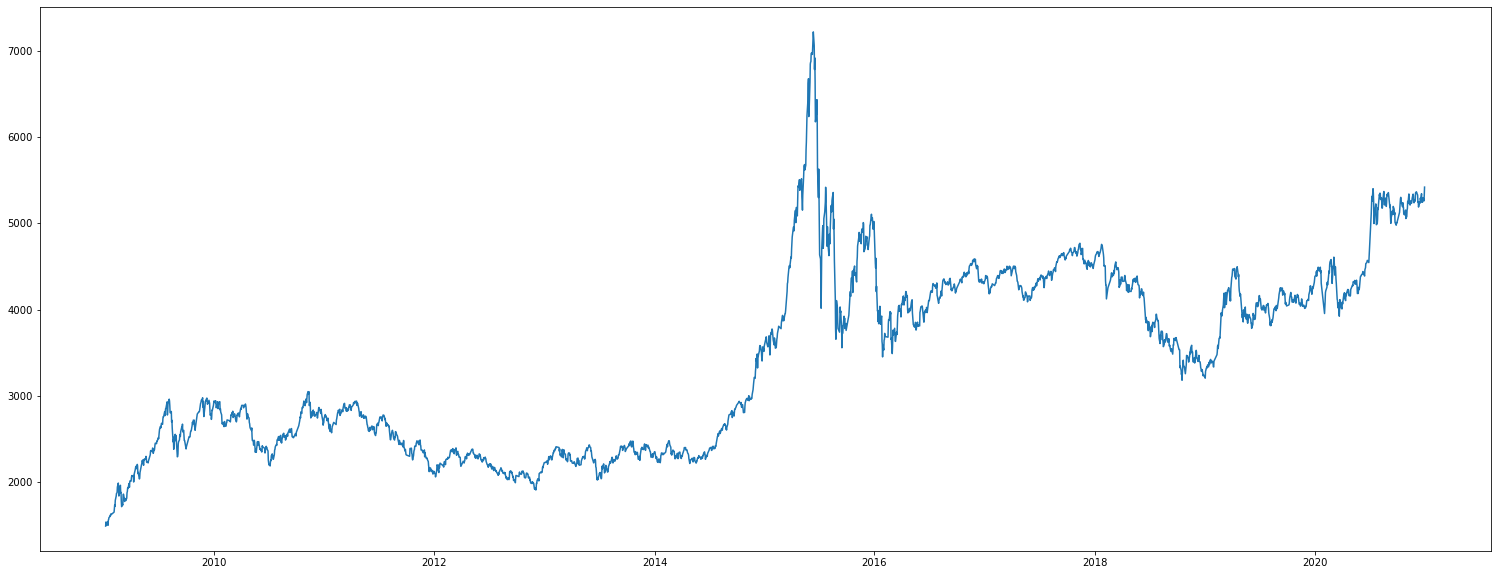

In [93]:
plt.figure(figsize=(26,10))
plt.plot(stockClosedf[stockClosedf.columns[stock_num]])

## 策略资金变化和股票仓位比关系

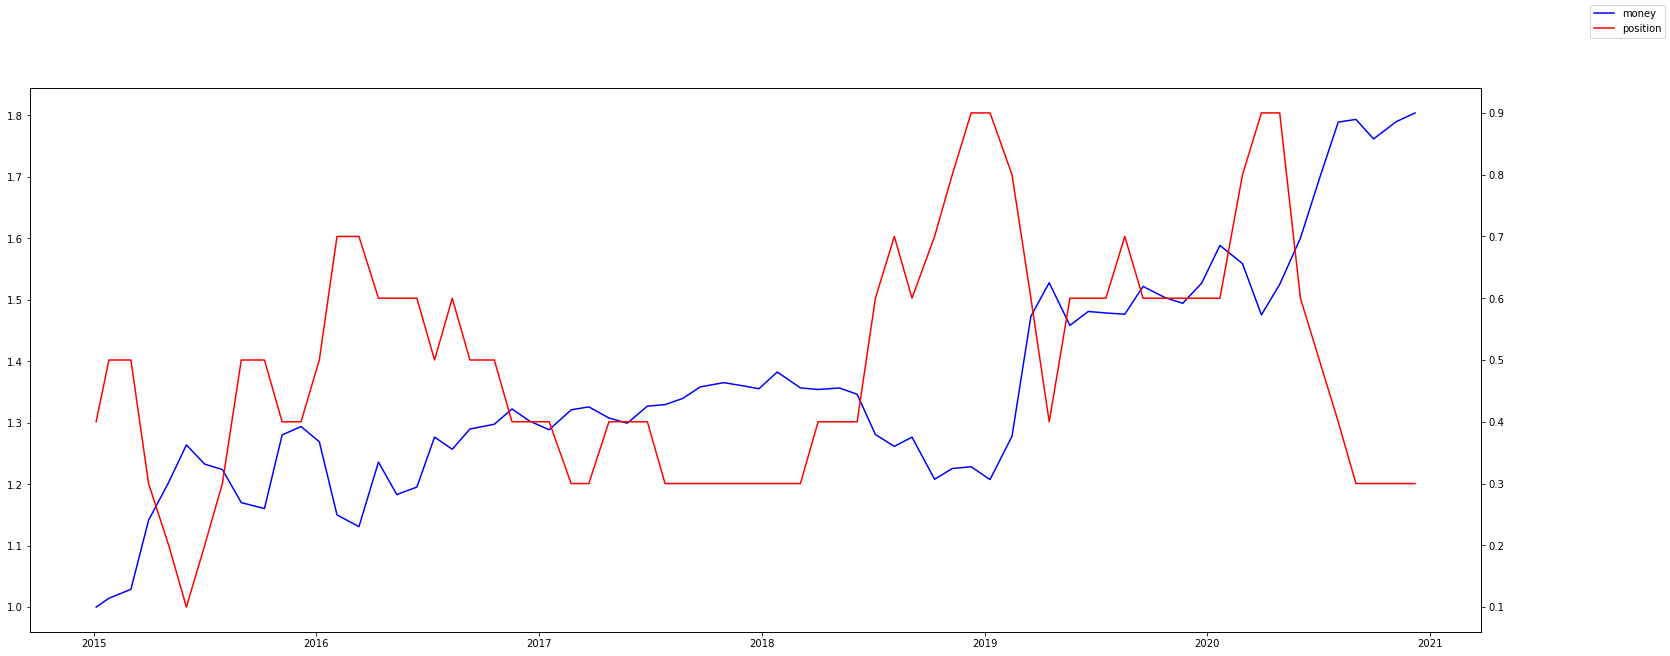

In [94]:
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,money_all,color = 'blue',label = 'money')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(150))
# ax1.grid()
ax2 = ax1.twinx() 
ax2.plot(time_all,position_all,color = 'red',label = 'position')
fig.legend()

## 收益率变化情况

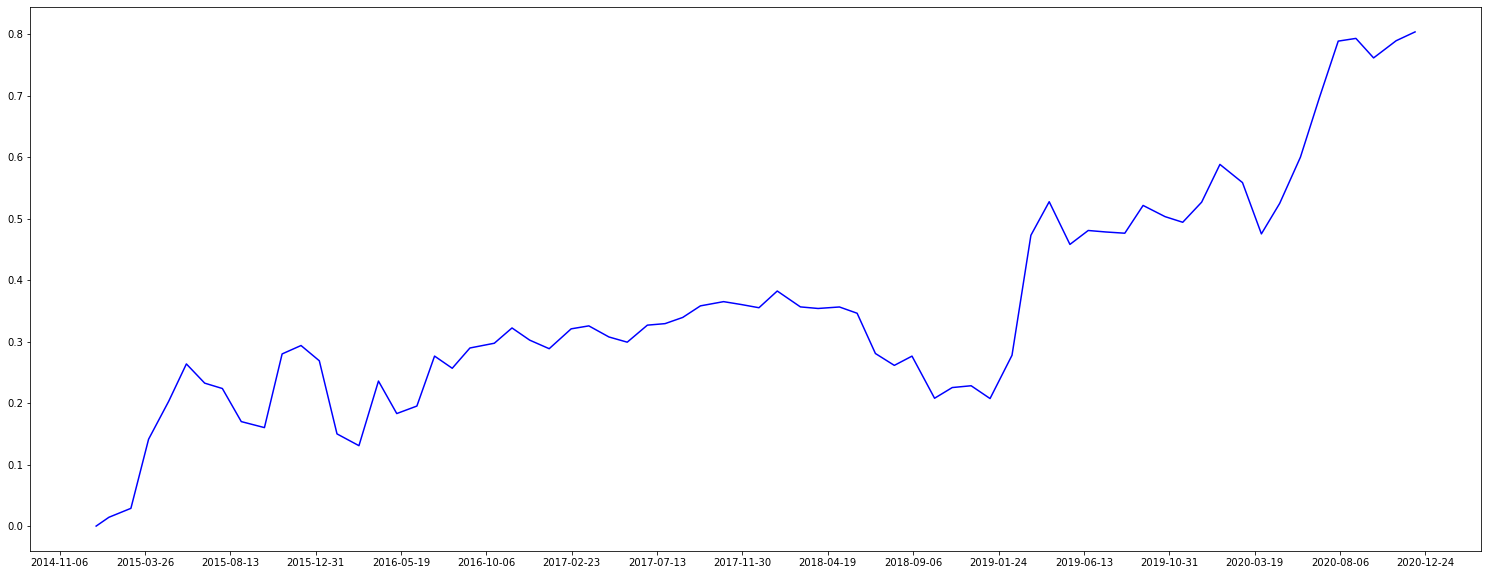

In [95]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,[i-1 for i in money_all],color = 'blue')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(140))
# ax1.grid()
# ax2 = ax1.twinx() 
# ax1.plot(time_all,[i-1 for i in money_all/money_all[0]],color = 'red')

## 策略最大回撤

In [96]:
max_drawdown = 0
max_drawdown_start = 0
max_drawdown_end = 0
for i in range(len(money_all)):
    for j in range(i+1,len(money_all)):
        if (money_all[i]-money_all[j])>max_drawdown:
            max_drawdown_start = i
            max_drawdown_end = j
            max_drawdown = money_all[i]-money_all[j]
print("策略最大回撤："+str(max_drawdown/money_all[max_drawdown_start])+"   时间："+str(time_all[max_drawdown_start]) + "("+str(np.around(money_all[max_drawdown_start],decimals =3))
      +") 至 "+str(time_all[max_drawdown_end])+ "("+str(np.around(money_all[max_drawdown_end],decimals =3))+")")

策略最大回撤：0.12654328482823   时间：2018-01-26(1.382) 至 2019-01-10(1.208)


In [97]:
stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

资金   仓位     策略收益率  881001.WI     指数收益率
2015-01-05         1  0.4  0.000000  3654.6299  0.000000
2015-01-26  1.014374  0.5  0.014272  3774.7591  0.032342
2015-03-03  1.028882  0.5  0.014201  3870.0943  0.024942
2015-04-01  1.141334  0.3  0.103725  4705.2927  0.195409
2015-05-04  1.203097  0.2  0.052702  5519.1104  0.159529
2015-06-02  1.263828  0.1  0.049246  6851.7341  0.216285
2015-07-02   1.23258  0.2 -0.025036  4975.3161 -0.320013
2015-07-31  1.223832  0.3 -0.007122  4743.5066 -0.047712
2015-08-31  1.170014  0.5 -0.044971  4015.5468 -0.166603
2015-10-08  1.160229  0.5 -0.008398  3934.5299 -0.020382
2015-11-06  1.280102  0.4  0.098322  4737.9198  0.185807
2015-12-07  1.293775  0.4  0.010624  4845.6710  0.022488
2016-01-06  1.268937  0.5 -0.019385  4595.6297 -0.052980
2016-02-04  1.150001  0.7 -0.098417  3723.8562 -0.210346
2016-03-11  1.130821  0.7 -0.016819  3630.6290 -0.025354
2016-04-12  1.235961  0.6  0.088905  4108.9729  0.123767
2016-05-12  1.183088  0.6 -0.043721  3809.4648 -0.075684
2016-06-14  1.195287  0.6  0.010258  3868.1333  0.015283
2016-07-13  1.276571  0.5  0.065792  4300.6545  0.105995
2016-08-11  1.256769  0.6 -0.015633  4157.7337 -0.033797
2016-09-09  1.289766  0.5  0.025916  4333.6867  0.041448
2016-10-19   1.29749  0.5  0.005971  4372.6182  0.008943
2016-11-17  1.322356  0.4  0.018983  4530.6667  0.035507
2016-12-16  1.302549  0.4 -0.015091  4344.7809 -0.041894
2017-01-17  1.288604  0.4 -0.010764  4210.2410 -0.031455
2017-02-22  1.320901  0.3  0.024754  4453.1565  0.056093
2017-03-23  1.325739  0.3  0.003656  4479.9412  0.005997
2017-04-25  1.307684  0.4 -0.013712  4244.9811 -0.053873
2017-05-25  1.299226  0.4 -0.006490  4157.5835 -0.020803
2017-06-27  1.326922  0.4  0.021093  4358.9623  0.047300
2017-07-26  1.329391  0.3  0.001859  4360.6756  0.000393
2017-08-24  1.339474  0.3  0.007556  4441.6692  0.018403
2017-09-22  1.358286  0.3  0.013946  4619.7341  0.039307
2017-10-30  1.365169  0.3  0.005054  4656.2490  0.007873
2017-11-28  1.360475  0.3 -0.003444  4569.0251 -0.018910
2017-12-27  1.355254  0.3 -0.003845  4477.5067 -0.020234
2018-01-26  1.382456  0.3  0.019873  4743.2999  0.057667
2018-03-05   1.35661  0.3 -0.018873  4403.0184 -0.074443
2018-04-03  1.354058  0.4 -0.001883  4344.4897 -0.013382
2018-05-08  1.356489  0.4  0.001794  4341.2048 -0.000756
2018-06-06  1.346277  0.4 -0.007557  4240.5291 -0.023464
2018-07-06   1.28079  0.6 -0.049866  3706.1205 -0.134702
2018-08-06  1.261463  0.7 -0.015205  3605.5606 -0.027508
2018-09-04  1.276525  0.6  0.011869  3662.6577  0.015712
2018-10-11  1.207987  0.7 -0.055187  3325.8950 -0.096450
2018-11-09  1.225396  0.8  0.014309  3390.3621  0.019198
2018-12-10   1.22832  0.9  0.002383  3398.0427  0.002263
2019-01-10  1.207516  0.9 -0.017082  3333.0501 -0.019312
2019-02-15  1.277894  0.8  0.056648  3547.7599  0.062429
2019-03-18  1.473132  0.6  0.142178  4222.9233  0.174211
2019-04-17  1.527728  0.4  0.036391  4476.3576  0.058282
2019-05-21  1.458279  0.6 -0.046525  3946.6978 -0.125930
2019-06-20  1.480929  0.6  0.015413  4041.8110  0.023814
2019-07-19  1.478501  0.6 -0.001641  4023.9310 -0.004434
2019-08-19  1.476503  0.7 -0.001352  4007.8211 -0.004012
2019-09-18  1.521679  0.6  0.030138  4178.6862  0.041749
2019-10-24  1.503473  0.6 -0.012037  4086.6986 -0.022259
2019-11-22  1.494297  0.6 -0.006122  4038.0896 -0.011966
2019-12-23     1.527  0.6  0.021649  4178.1050  0.034086
2020-01-22  1.588446  0.6  0.039451  4451.1856  0.063313
2020-02-28  1.558852  0.8 -0.018806  4304.3983 -0.033533
2020-03-30  1.475405  0.9 -0.055017  4013.9430 -0.069863
2020-04-29  1.525053  0.9  0.033097  4163.0848  0.036482
2020-06-02  1.600192  0.6  0.048094  4389.8386  0.053036
2020-07-03  1.696591  0.5  0.058497  4823.5420  0.094216
2020-08-03  1.789023  0.4  0.053049  5337.0081  0.101157
2020-09-01  1.793448  0.3  0.002470  5350.9937  0.002617
2020-09-30  1.761716  0.3 -0.017851  5004.5431 -0.066936
2020-11-06  1.789666  0.3  0.015741  5231.4378  0.044340
2020-12-07  1.804012  0.3  0

## 策略表现
### 年化波动率计算：标准差*(N^0.5)

In [99]:
time_temp = ['2015年','2016年','2017年','2018年','2019年','2020年','六年总计'] 
return_temp = [money_all[11]/money_all[0]-1,money_all[23]/money_all[11]-1,money_all[35]/money_all[23]-1,money_all[46]/money_all[35]-1,
               money_all[58]/money_all[46]-1,money_all[-1]/money_all[58]-1,money_all[-1]/money_all[0]-1]
money_temp = [money_all[11],money_all[23],money_all[35],money_all[46], money_all[58],money_all[-1],money_all[-1]]
return_volatility = [info.iloc[:12].std()[2]*(12**0.5),info.iloc[12:24].std()[2]*(12**0.5),info.iloc[24:36].std()[2]*(12**0.5),
                     info.iloc[36:47].std()[2]*(11**0.5),info.iloc[47:59].std()[2]*(12**0.5),info.iloc[59:].std()[2]*(11**0.5)]
return_volatility.append(sum([i/len(return_volatility) for i in return_volatility]))
sharpe_ratio_strategy = [(return_temp[0] - bonddf.loc[time_all[0]:time_all[11]].mean()[0])/info.iloc[:12].std()[2],(return_temp[1] - bonddf.loc[time_all[11]:time_all[23]].mean()[0])/info.iloc[12:24].std()[2],
                        (return_temp[2] - bonddf.loc[time_all[23]:time_all[35]].mean()[0])/info.iloc[24:36].std()[2],(return_temp[3] - bonddf.loc[time_all[35]:time_all[46]].mean()[0])/info.iloc[36:47].std()[2],
                         (return_temp[4] - bonddf.loc[time_all[46]:time_all[58]].mean()[0])/info.iloc[47:59].std()[2],
                         (return_temp[5] - bonddf.loc[time_all[58]:time_all[-1]].mean()[0])/info.iloc[59:].std()[2], (return_temp[6] - bonddf.loc[time_all[0]:time_all[-1]].mean()[0])/info.std()[2]]

index_temp = [stockClose.loc[info.index[11]],stockClose.loc[info.index[23]],stockClose.loc[info.index[35]],stockClose.loc[info.index[46]],
              stockClose.loc[info.index[58]],stockClose.loc[info.index[-1]],stockClose.loc[info.index[-1]]]
index_return = [stockClose.loc[info.index[11]]/stockClose.loc[info.index[0]]-1,stockClose.loc[info.index[23]]/stockClose.loc[info.index[11]]-1,stockClose.loc[info.index[35]]/stockClose.loc[info.index[23]]-1,
               stockClose.loc[info.index[46]]/stockClose.loc[info.index[35]]-1,stockClose.loc[info.index[58]]/stockClose.loc[info.index[46]]-1,
                stockClose.loc[info.index[-1]]/stockClose.loc[info.index[58]]-1,stockClose.loc[info.index[-1]]/stockClose.loc[info.index[0]]-1]
index_return_volatility = [info.iloc[:12].std()[4]*(12**0.5),info.iloc[12:24].std()[4]*(12**0.5),info.iloc[24:36].std()[4]*(12**0.5),info.iloc[36:47].std()[4]*(11**0.5),
                           info.iloc[47:59].std()[4]*(12**0.5), info.iloc[59:].std()[4]*(11**0.5)]
index_return_volatility.append(sum([i/len(index_return_volatility) for i in index_return_volatility]))
sharpe_ratio_index = [(index_return[0] - bonddf.loc[time_all[0]:time_all[11]].mean()[0])/info.iloc[:12].std()[4],(index_return[1] - bonddf.loc[time_all[11]:time_all[23]].mean()[0])/info.iloc[12:24].std()[4],
                        (index_return[2] - bonddf.loc[time_all[23]:time_all[35]].mean()[0])/info.iloc[24:36].std()[4],(index_return[3] - bonddf.loc[time_all[35]:time_all[46]].mean()[0])/info.iloc[36:47].std()[4],
                         (index_return[4] - bonddf.loc[time_all[46]:time_all[58]].mean()[0])/info.iloc[47:59].std()[4],
                         (index_return[5] - bonddf.loc[time_all[58]:time_all[-1]].mean()[0])/info.iloc[59:].std()[4], (index_return[6] - bonddf.loc[time_all[0]:time_all[-1]].mean()[0])/info.std()[4]]

return_bond = [bonddf.loc[time_all[0]:time_all[11]].mean()[0],bonddf.loc[time_all[11]:time_all[23]].mean()[0],bonddf.loc[time_all[23]:time_all[35]].mean()[0],
              bonddf.loc[time_all[35]:time_all[46]].mean()[0],bonddf.loc[time_all[46]:time_all[58]].mean()[0],
              bonddf.loc[time_all[58]:time_all[-1]].mean()[0],bonddf.loc[time_all[0]:time_all[-1]].mean()[0]]

info_temp = pd.DataFrame([time_temp,money_temp,return_temp,return_volatility,sharpe_ratio_strategy,index_temp,index_return,index_return_volatility,sharpe_ratio_index,return_bond], 
                         index=['时间','资金', '策略收益率','策略年化波动率','策略夏普率','指数','指数收益率','指数年化波动率','指数夏普率','十年国债收益率']).T.set_index(['时间'])
info_temp

资金     策略收益率   策略年化波动率      策略夏普率         指数     指数收益率   指数年化波动率  \
时间                                                                              
2015年  1.293775  0.293775  0.159736   5.633067   4845.671  0.325899  0.546064   
2016年  1.302549  0.006782  0.168835  -0.445374  4344.7809 -0.103369  0.304823   
2017年  1.355254  0.040463   0.04169    0.40268  4477.5067  0.030548   0.11622   
2018年   1.22832 -0.093661  0.081581  -5.291121  3398.0427 -0.241086  0.186156   
2019年     1.527  0.243161  0.165335   4.426642   4178.105  0.229562  0.243749   
2020年  1.804012  0.181409  0.118155   4.269785  5337.2693  0.277438   0.19529   
六年总计   1.804012  0.804012  0.122555  19.970418  5337.2693  0.460413  0.265384   

          指数夏普率   十年国债收益率  
时间                         
2015年  1.851583  0.034025  
2016年 -1.498465  0.028489  
2017年 -0.151067  0.035617  
2018年 -4.945384  0.036489  
2019年  2.809319  0.031886  
2020年  4.214175  0.029298  
六年总计   4.961083  0.032598

# 仅含万得全A策略 (资金投入日期：2016年初）

In [100]:
stock_num = -1
testStartDate  = datetime.date.fromisoformat('2016-01-04')
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

881001.WI
训练开始日期(2009-01-05)：1486.1136   测试开始日期(2016-01-04)：4949.1953    结束日期(2020-12-31)：5422.197
指数总收益率： 0.0955714356230799   指数年化收益率： 0.01842286228941936
策略总收益率： 0.4313809272954656   策略年化收益率： 0.07436300487380154



## 指数历史走势

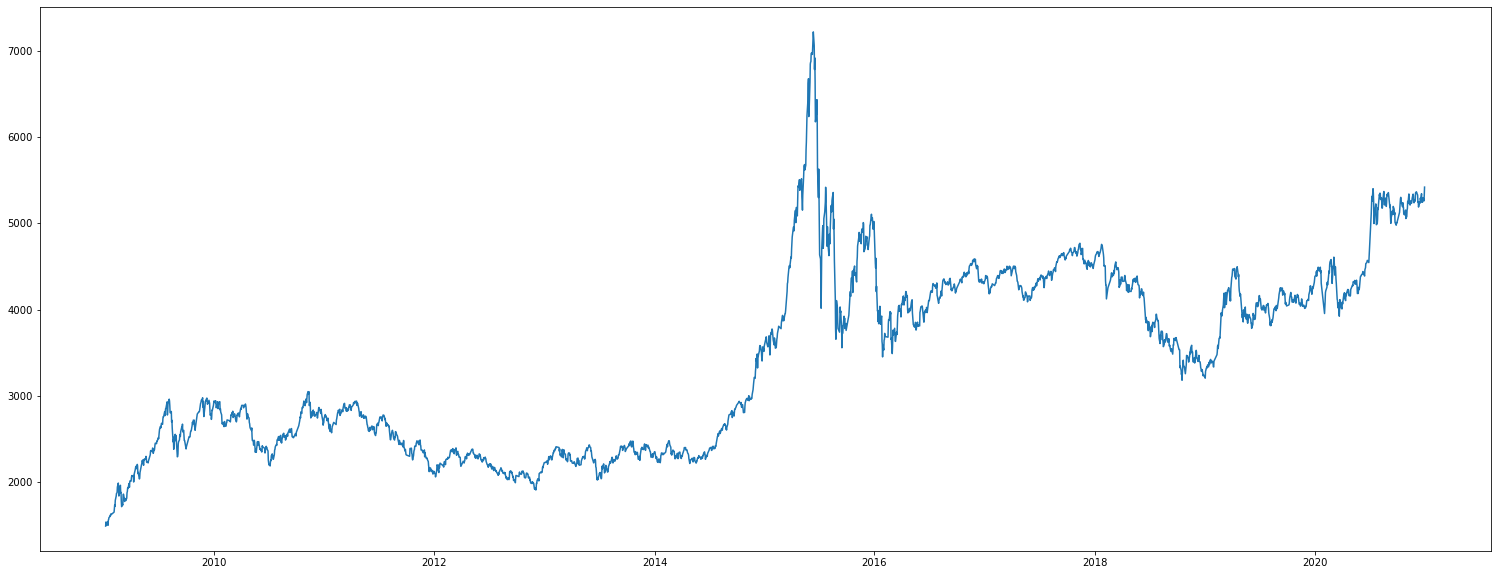

In [101]:
plt.figure(figsize=(26,10))
plt.plot(stockClosedf[stockClosedf.columns[stock_num]])

## 策略资金变化和股票仓位比关系

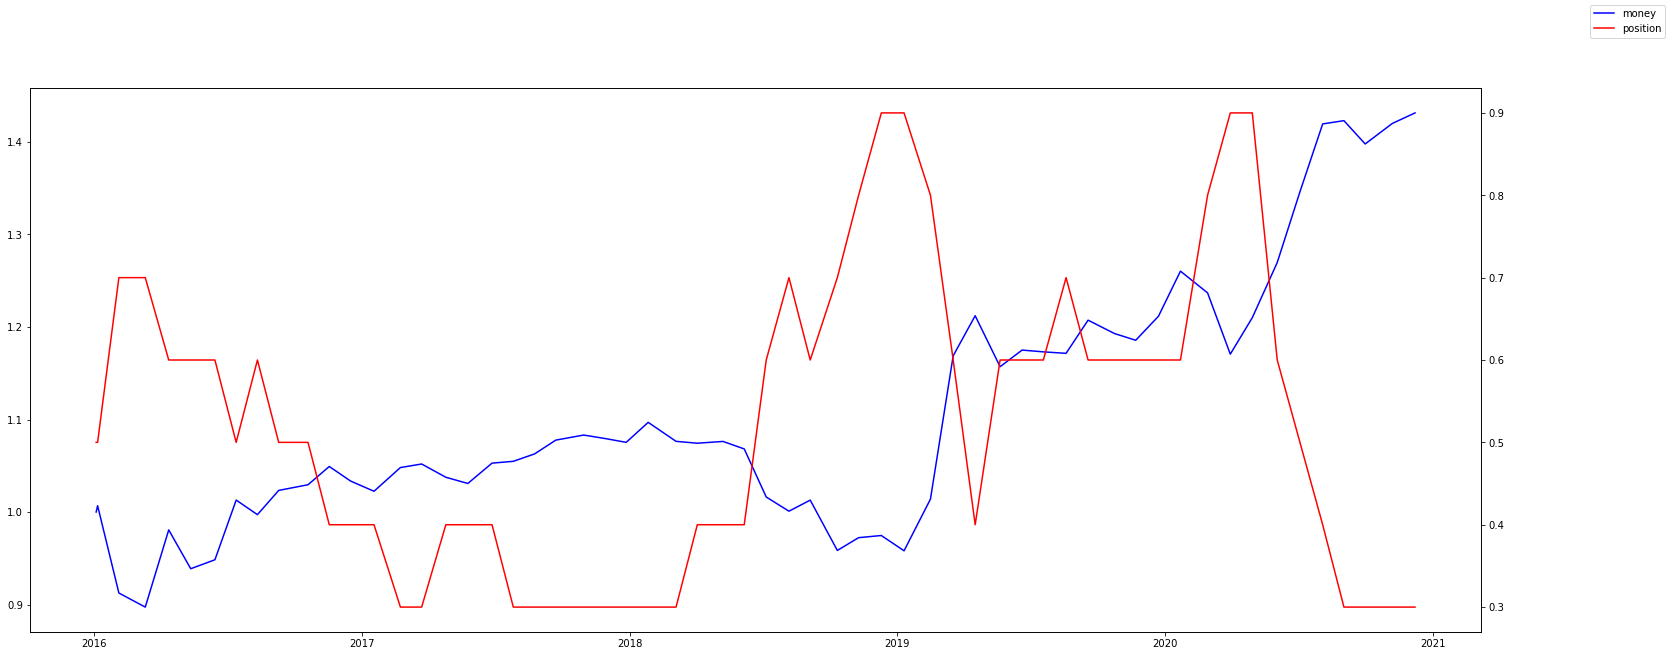

In [102]:
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,money_all,color = 'blue',label = 'money')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(150))
# ax1.grid()
ax2 = ax1.twinx() 
ax2.plot(time_all,position_all,color = 'red',label = 'position')
fig.legend()

## 收益率变化情况

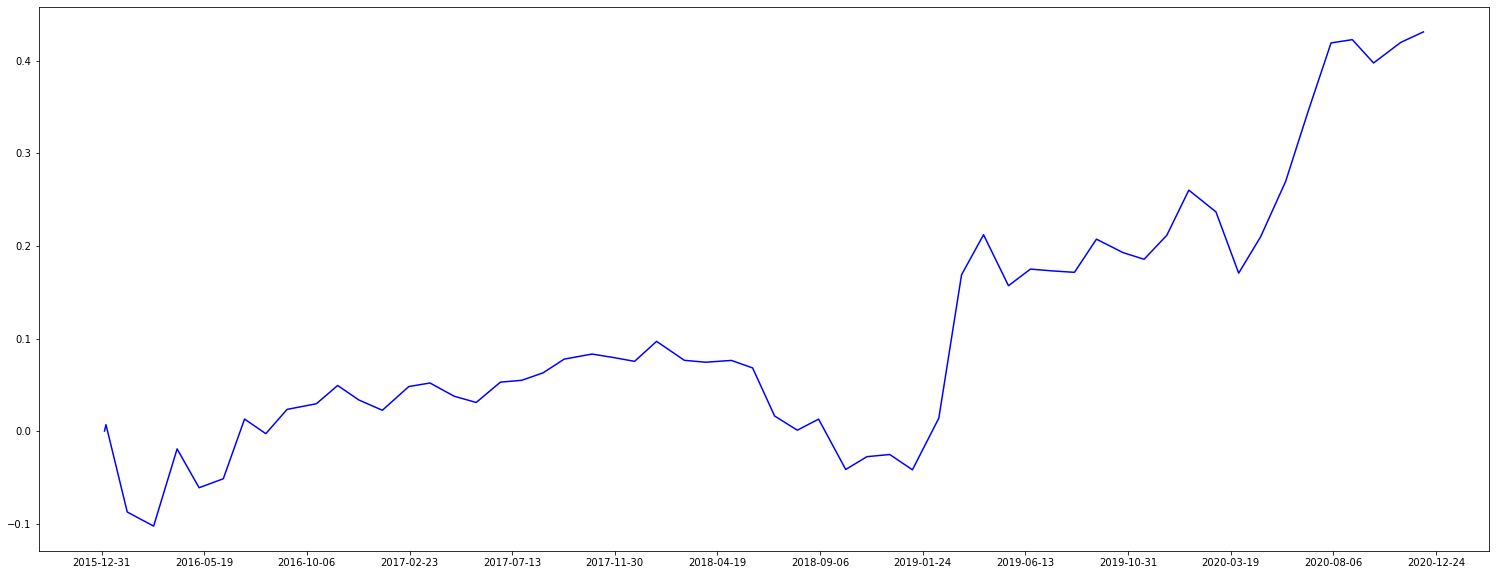

In [103]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,[i-1 for i in money_all],color = 'blue')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(140))
# ax1.grid()
# ax2 = ax1.twinx() 
# ax1.plot(time_all,[i-1 for i in money_all/money_all[0]],color = 'red')

## 策略最大回撤

In [104]:
max_drawdown = 0
max_drawdown_start = 0
max_drawdown_end = 0
for i in range(len(money_all)):
    for j in range(i+1,len(money_all)):
        if (money_all[i]-money_all[j])>max_drawdown:
            max_drawdown_start = i
            max_drawdown_end = j
            max_drawdown = money_all[i]-money_all[j]
print("策略最大回撤："+str(max_drawdown/money_all[max_drawdown_start])+"   时间："+str(time_all[max_drawdown_start]) + "("+str(np.around(money_all[max_drawdown_start],decimals =3))
      +") 至 "+str(time_all[max_drawdown_end])+ "("+str(np.around(money_all[max_drawdown_end],decimals =3))+")")

策略最大回撤：0.12654328482823007   时间：2018-01-26(1.097) 至 2019-01-10(0.958)


In [105]:
stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

资金   仓位     策略收益率  881001.WI     指数收益率
2016-01-04         1  0.5  0.000000  4534.4075  0.000000
2016-01-06   1.00683  0.5  0.006807  4595.6297  0.013411
2016-02-04   0.91246  0.7 -0.098417  3723.8562 -0.210346
2016-03-11  0.897242  0.7 -0.016819  3630.6290 -0.025354
2016-04-12  0.980665  0.6  0.088905  4108.9729  0.123767
2016-05-12  0.938713  0.6 -0.043721  3809.4648 -0.075684
2016-06-14  0.948392  0.6  0.010258  3868.1333  0.015283
2016-07-13  1.012886  0.5  0.065792  4300.6545  0.105995
2016-08-11  0.997175  0.6 -0.015633  4157.7337 -0.033797
2016-09-09  1.023356  0.5  0.025916  4333.6867  0.041448
2016-10-19  1.029485  0.5  0.005971  4372.6182  0.008943
2016-11-17  1.049214  0.4  0.018983  4530.6667  0.035507
2016-12-16  1.033499  0.4 -0.015091  4344.7809 -0.041894
2017-01-17  1.022434  0.4 -0.010764  4210.2410 -0.031455
2017-02-22   1.04806  0.3  0.024754  4453.1565  0.056093
2017-03-23  1.051899  0.3  0.003656  4479.9412  0.005997
2017-04-25  1.037573  0.4 -0.013712  4244.9811 -0.053873
2017-05-25  1.030862  0.4 -0.006490  4157.5835 -0.020803
2017-06-27  1.052837  0.4  0.021093  4358.9623  0.047300
2017-07-26  1.054796  0.3  0.001859  4360.6756  0.000393
2017-08-24  1.062797  0.3  0.007556  4441.6692  0.018403
2017-09-22  1.077723  0.3  0.013946  4619.7341  0.039307
2017-10-30  1.083184  0.3  0.005054  4656.2490  0.007873
2017-11-28  1.079459  0.3 -0.003444  4569.0251 -0.018910
2017-12-27  1.075317  0.3 -0.003845  4477.5067 -0.020234
2018-01-26    1.0969  0.3  0.019873  4743.2999  0.057667
2018-03-05  1.076393  0.3 -0.018873  4403.0184 -0.074443
2018-04-03  1.074368  0.4 -0.001883  4344.4897 -0.013382
2018-05-08  1.076297  0.4  0.001794  4341.2048 -0.000756
2018-06-06  1.068194  0.4 -0.007557  4240.5291 -0.023464
2018-07-06  1.016234  0.6 -0.049866  3706.1205 -0.134702
2018-08-06  1.000899  0.7 -0.015205  3605.5606 -0.027508
2018-09-04   1.01285  0.6  0.011869  3662.6577  0.015712
2018-10-11  0.958469  0.7 -0.055187  3325.8950 -0.096450
2018-11-09  0.972282  0.8  0.014309  3390.3621  0.019198
2018-12-10  0.974602  0.9  0.002383  3398.0427  0.002263
2019-01-10  0.958095  0.9 -0.017082  3333.0501 -0.019312
2019-02-15  1.013936  0.8  0.056648  3547.7599  0.062429
2019-03-18  1.168847  0.6  0.142178  4222.9233  0.174211
2019-04-17  1.212165  0.4  0.036391  4476.3576  0.058282
2019-05-21  1.157061  0.6 -0.046525  3946.6978 -0.125930
2019-06-20  1.175033  0.6  0.015413  4041.8110  0.023814
2019-07-19  1.173106  0.6 -0.001641  4023.9310 -0.004434
2019-08-19  1.171521  0.7 -0.001352  4007.8211 -0.004012
2019-09-18  1.207366  0.6  0.030138  4178.6862  0.041749
2019-10-24  1.192921  0.6 -0.012037  4086.6986 -0.022259
2019-11-22  1.185639  0.6 -0.006122  4038.0896 -0.011966
2019-12-23  1.211588  0.6  0.021649  4178.1050  0.034086
2020-01-22  1.260342  0.6  0.039451  4451.1856  0.063313
2020-02-28  1.236861  0.8 -0.018806  4304.3983 -0.033533
2020-03-30   1.17065  0.9 -0.055017  4013.9430 -0.069863
2020-04-29  1.210043  0.9  0.033097  4163.0848  0.036482
2020-06-02  1.269661  0.6  0.048094  4389.8386  0.053036
2020-07-03  1.346148  0.5  0.058497  4823.5420  0.094216
2020-08-03  1.419488  0.4  0.053049  5337.0081  0.101157
2020-09-01  1.422999  0.3  0.002470  5350.9937  0.002617
2020-09-30  1.397822  0.3 -0.017851  5004.5431 -0.066936
2020-11-06  1.419999  0.3  0.015741  5231.4378  0.044340
2020-12-07  1.431381  0.3  0.007984  5337.2693  0.020028

## 策略表现
### 年化波动率计算：标准差*(N^0.5)

In [107]:
time_temp = ['2016年','2017年','2018年','2019年','2020年','五年总计'] 
return_temp = [money_all[12]/money_all[0]-1,money_all[24]/money_all[12]-1,money_all[35]/money_all[24]-1,money_all[47]/money_all[35]-1,money_all[-1]/money_all[47]-1,money_all[-1]/money_all[0]-1]
money_temp = [money_all[12],money_all[24],money_all[35],money_all[47],money_all[-1],money_all[-1]]
return_volatility = [info.iloc[:13].std()[2]*(13**0.5),info.iloc[13:25].std()[2]*(12**0.5),info.iloc[25:36].std()[2]*(11**0.5),
                     info.iloc[36:48].std()[2]*(12**0.5),info.iloc[48:].std()[2]*(11**0.5)]
return_volatility.append(sum([i/len(return_volatility) for i in return_volatility]))
sharpe_ratio_strategy = [(return_temp[0] - bonddf.loc[time_all[0]:time_all[12]].mean()[0])/info.iloc[:13].std()[2],(return_temp[1] - bonddf.loc[time_all[12]:time_all[24]].mean()[0])/info.iloc[13:25].std()[2],
                        (return_temp[2] - bonddf.loc[time_all[24]:time_all[35]].mean()[0])/info.iloc[25:36].std()[2],(return_temp[3] - bonddf.loc[time_all[35]:time_all[47]].mean()[0])/info.iloc[36:48].std()[2],
                         (return_temp[4] - bonddf.loc[time_all[47]:time_all[-1]].mean()[0])/info.iloc[48:].std()[2], (return_temp[5] - bonddf.loc[time_all[0]:time_all[-1]].mean()[0])/info.std()[2]]

index_temp = [stockClose.loc[info.index[12]],stockClose.loc[info.index[24]],stockClose.loc[info.index[35]],stockClose.loc[info.index[47]],stockClose.loc[info.index[-1]],stockClose.loc[info.index[-1]]]
index_return = [stockClose.loc[info.index[12]]/stockClose.loc[info.index[0]]-1,stockClose.loc[info.index[24]]/stockClose.loc[info.index[12]]-1,stockClose.loc[info.index[35]]/stockClose.loc[info.index[24]]-1,
               stockClose.loc[info.index[47]]/stockClose.loc[info.index[35]]-1,stockClose.loc[info.index[-1]]/stockClose.loc[info.index[47]]-1,stockClose.loc[info.index[-1]]/stockClose.loc[info.index[0]]-1]
index_return_volatility = [info.iloc[:13].std()[4]*(13**0.5),info.iloc[13:25].std()[4]*(12**0.5),info.iloc[25:36].std()[4]*(11**0.5),
                           info.iloc[36:48].std()[4]*(12**0.5),info.iloc[48:].std()[4]*(11**0.5)]
index_return_volatility.append(sum([i/len(index_return_volatility) for i in index_return_volatility]))
sharpe_ratio_index = [(index_return[0] - bonddf.loc[time_all[0]:time_all[12]].mean()[0])/info.iloc[:13].std()[4],(index_return[1] - bonddf.loc[time_all[12]:time_all[24]].mean()[0])/info.iloc[13:25].std()[4],
                        (index_return[2] - bonddf.loc[time_all[24]:time_all[35]].mean()[0])/info.iloc[25:36].std()[4],(index_return[3] - bonddf.loc[time_all[35]:time_all[47]].mean()[0])/info.iloc[36:48].std()[4],
                         (index_return[4] - bonddf.loc[time_all[47]:time_all[-1]].mean()[0])/info.iloc[48:].std()[4], (index_return[5] - bonddf.loc[time_all[0]:time_all[-1]].mean()[0])/info.std()[4]]

return_bond = [bonddf.loc[time_all[0]:time_all[12]].mean()[0],bonddf.loc[time_all[12]:time_all[24]].mean()[0],bonddf.loc[time_all[24]:time_all[35]].mean()[0],
              bonddf.loc[time_all[35]:time_all[47]].mean()[0], bonddf.loc[time_all[47]:time_all[-1]].mean()[0],bonddf.loc[time_all[0]:time_all[-1]].mean()[0]]

info_temp = pd.DataFrame([time_temp,money_temp,return_temp,return_volatility,sharpe_ratio_strategy,index_temp,index_return,index_return_volatility,sharpe_ratio_index,return_bond], 
                         index=['时间','资金', '策略收益率','策略年化波动率','策略夏普率','指数','指数收益率','指数年化波动率','指数夏普率','十年国债收益率']).T.set_index(['时间'])
info_temp

资金     策略收益率   策略年化波动率      策略夏普率         指数     指数收益率   指数年化波动率  \
时间                                                                              
2016年  1.033499  0.033499  0.166926   0.109678  4344.7809 -0.041819  0.300581   
2017年  1.075317  0.040463   0.04169    0.40268  4477.5067  0.030548   0.11622   
2018年  0.974602 -0.093661  0.081581  -5.291121  3398.0427 -0.241086  0.186156   
2019年  1.211588  0.243161  0.165335   4.426642   4178.105  0.229562  0.243749   
2020年  1.431381  0.181409  0.118155   4.269785  5337.2693  0.277438   0.19529   
五年总计   1.431381  0.431381  0.114737  10.986343  5337.2693   0.17706  0.208399   

          指数夏普率   十年国债收益率  
时间                         
2016年 -0.842557  0.028421  
2017年 -0.151067  0.035617  
2018年 -4.945384  0.036489  
2019年  2.809319  0.031886  
2020年  4.214175  0.029298  
五年总计   2.287054  0.032379

# 仅含沪深300的策略
### 策略年化收益率与股债比第五版有微差的原因：第五版默认国债收益率为常数4%

In [17]:
stock_num = 0
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

000300.SH
训练开始日期(2009-01-05)：1882.959   测试开始日期(2016-01-04)：3731.0047    结束日期(2020-12-31)：5211.2885
指数总收益率： 0.3967520598406107   指数年化收益率： 0.06911362446365121
策略总收益率： 0.49403203524084627   策略年化收益率： 0.08360744932793618



## 指数历史走势

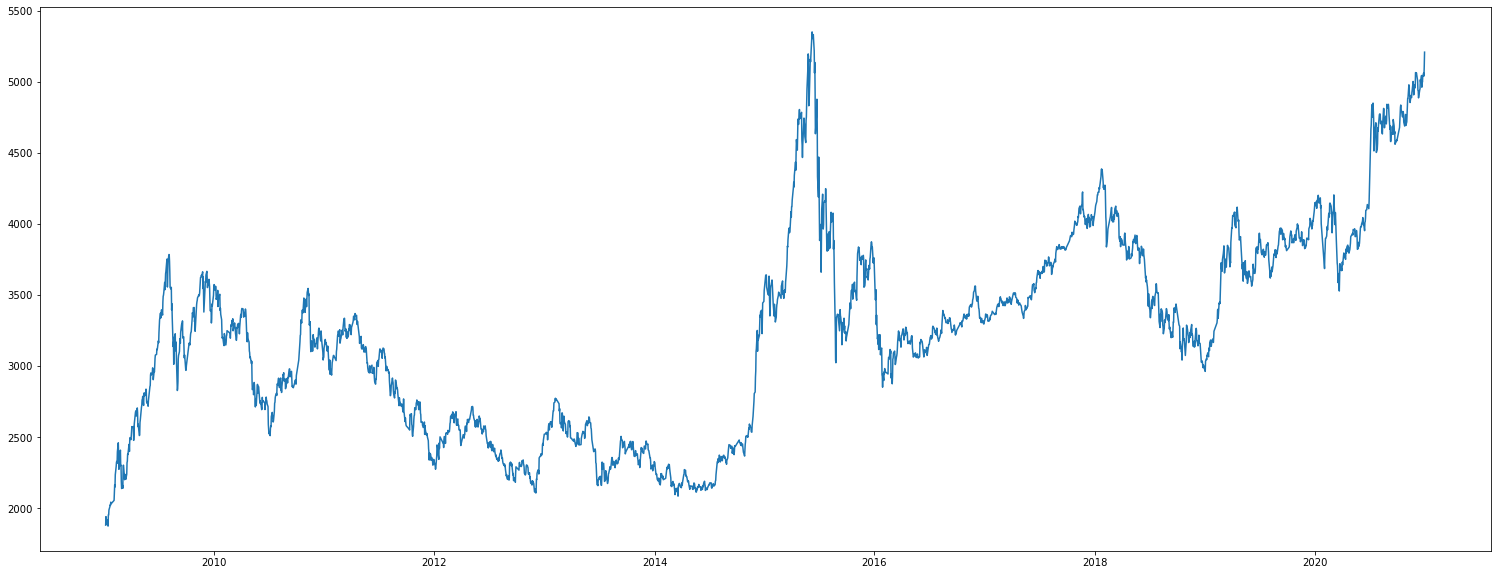

In [18]:
plt.figure(figsize=(26,10))
plt.plot(stockClosedf[stockClosedf.columns[stock_num]])

## 策略资金变化和股票仓位比关系

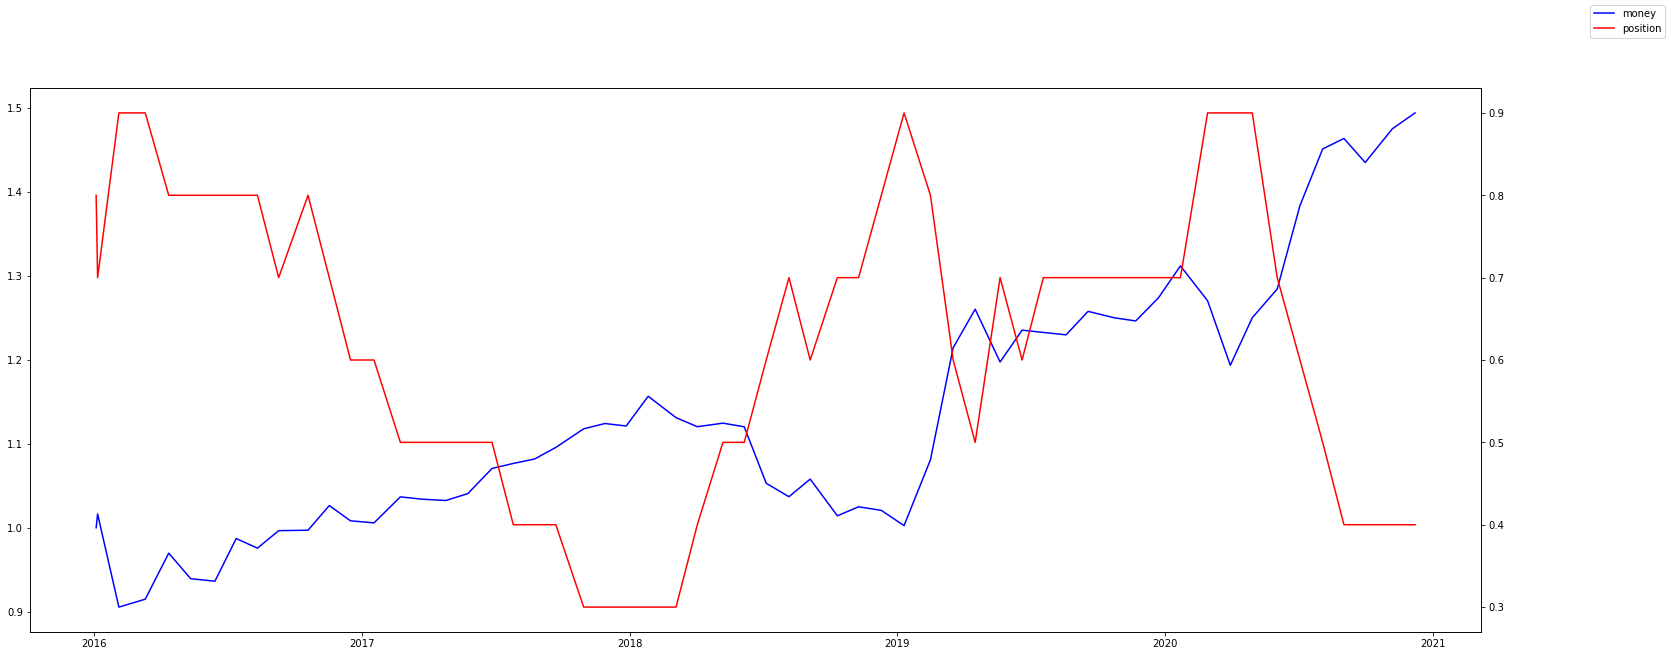

In [19]:
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,money_all,color = 'blue',label = 'money')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(150))
# ax1.grid()
ax2 = ax1.twinx() 
ax2.plot(time_all,position_all,color = 'red',label = 'position')
fig.legend()

## 收益率变化情况

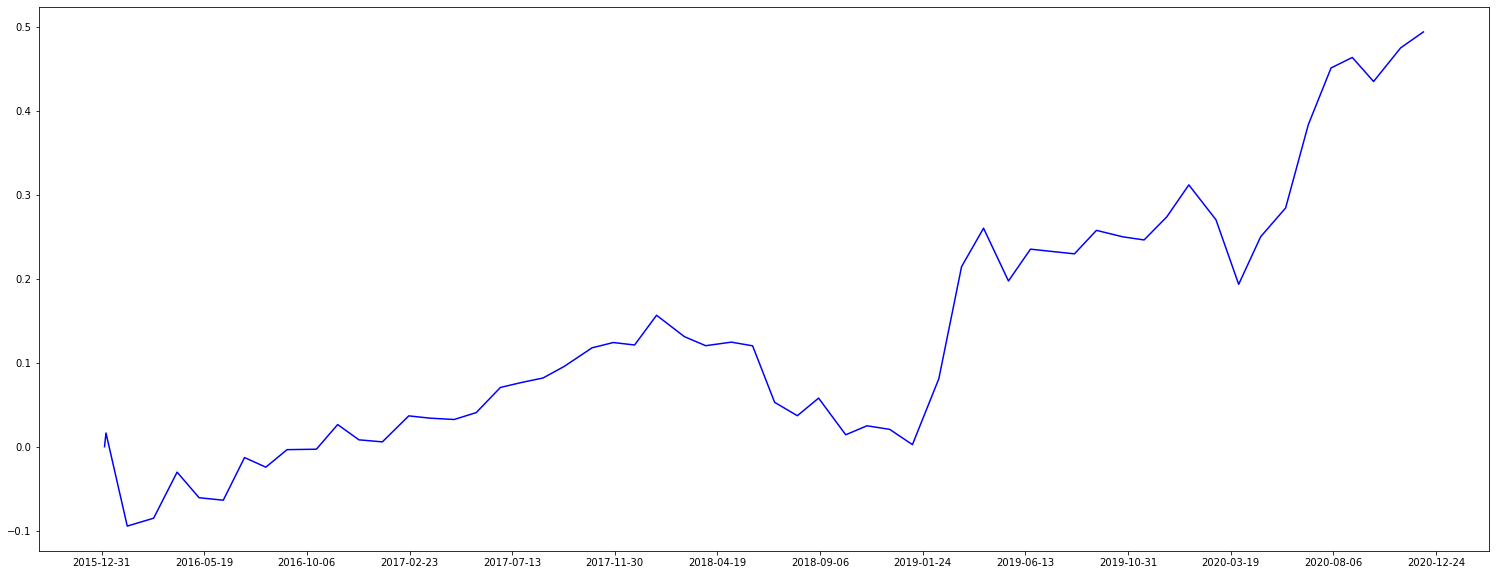

In [20]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,[i-1 for i in money_all],color = 'blue')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(140))
# ax1.grid()
# ax2 = ax1.twinx() 
# ax1.plot(time_all,[i-1 for i in money_all/money_all[0]],color = 'red')

## 策略最大回撤

In [21]:
max_drawdown = 0
max_drawdown_start = 0
max_drawdown_end = 0
for i in range(len(money_all)):
    for j in range(i+1,len(money_all)):
        if (money_all[i]-money_all[j])>max_drawdown:
            max_drawdown_start = i
            max_drawdown_end = j
            max_drawdown = money_all[i]-money_all[j]
print("策略最大回撤："+str(max_drawdown/money_all[max_drawdown_start])+"   时间："+str(time_all[max_drawdown_start]) + "("+str(np.around(money_all[max_drawdown_start],decimals =3))
      +") 至 "+str(time_all[max_drawdown_end])+ "("+str(np.around(money_all[max_drawdown_end],decimals =3))+")")

策略最大回撤：0.13319486843435308   时间：2018-01-26(1.157) 至 2019-01-10(1.003)


In [22]:
stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

资金   仓位     策略收益率  000300.SH     指数收益率
2016-01-04         1  0.8  0.000000  3469.0662  0.000000
2016-01-06  1.016345  0.7  0.016213  3539.8082  0.020187
2016-02-04  0.905472  0.9 -0.115512  2984.7598 -0.170553
2016-03-11  0.914881  0.9  0.010337  3018.2844  0.011169
2016-04-12  0.969715  0.8  0.058209  3218.4497  0.064211
2016-05-12   0.93925  0.8 -0.031920  3090.1372 -0.040684
2016-06-14  0.936311  0.8 -0.003134  3075.9834 -0.004591
2016-07-13  0.987119  0.8  0.052842  3282.8681  0.065093
2016-08-11  0.975646  0.8 -0.011691  3233.3604 -0.015195
2016-09-09  0.996509  0.7  0.021159  3318.0440  0.025853
2016-10-19  0.997025  0.8  0.000518  3316.2407 -0.000544
2016-11-17  1.026394  0.7  0.029031  3436.5350  0.035632
2016-12-16  1.008208  0.6 -0.017877  3346.0305 -0.026689
2017-01-17   1.00578  0.6 -0.002410  3326.3563 -0.005897
2017-02-22  1.036755  0.5  0.030332  3489.7567  0.047955
2017-03-23  1.034005  0.5 -0.002656  3461.9782 -0.007992
2017-04-25  1.032431  0.5 -0.001524  3440.9743 -0.006086
2017-05-25  1.040654  0.5  0.007934  3485.6581  0.012902
2017-06-27  1.070561  0.5  0.028333  3674.7152  0.052819
2017-07-26  1.076549  0.4  0.005578  3705.3884  0.008312
2017-08-24  1.081807  0.4  0.004872  3734.6458  0.007865
2017-09-22  1.095621  0.4  0.012689  3837.7304  0.027228
2017-10-30  1.117793  0.3  0.020035  4009.7218  0.043841
2017-11-28  1.124087  0.3  0.005615  4055.8235  0.011432
2017-12-27  1.121156  0.3 -0.002611  3991.2075 -0.016060
2018-01-26  1.156567  0.3  0.031096  4381.2996  0.093252
2018-03-05  1.131072  0.3 -0.022290  4018.0970 -0.086537
2018-04-03  1.120313  0.4 -0.009558  3862.4796 -0.039499
2018-05-08  1.124543  0.5  0.003769  3878.6767  0.004185
2018-06-06   1.12019  0.5 -0.003878  3837.3511 -0.010712
2018-07-06  1.052913  0.6 -0.061938  3365.1227 -0.131318
2018-08-06  1.036923  0.7 -0.015303  3273.2728 -0.027674
2018-09-04  1.057906  0.6  0.020034  3363.8984  0.027310
2018-10-11  1.014221  0.7 -0.042170  3124.1139 -0.073950
2018-11-09  1.024924  0.7  0.010497  3167.4442  0.013774
2018-12-10  1.020668  0.8 -0.004161  3144.7631 -0.007186
2019-01-10  1.002518  0.9 -0.017943  3072.6864 -0.023186
2019-02-15   1.08094  0.8  0.075316  3338.7047  0.083031
2019-03-18  1.214401  0.6  0.116420  3851.7479  0.142944
2019-04-17  1.260227  0.5  0.037041  4087.2398  0.059343
2019-05-21  1.197371  0.7 -0.051164  3666.7762 -0.108557
2019-06-20  1.235305  0.6  0.031190  3828.5183  0.043165
2019-07-19  1.232578  0.7 -0.002210  3807.9551 -0.005386
2019-08-19  1.229729  0.7 -0.002314  3791.0946 -0.004438
2019-09-18  1.257674  0.7  0.022470  3910.0837  0.030904
2019-10-24  1.249972  0.7 -0.006142  3870.6678 -0.010132
2019-11-22  1.246267  0.7 -0.002968  3849.9948 -0.005355
2019-12-23  1.273813  0.7  0.021861  3967.0962  0.029963
2020-01-22   1.31184  0.7  0.029416  4131.9311  0.040710
2020-02-28  1.270333  0.9 -0.032152  3940.0488 -0.047552
2020-03-30  1.193451  0.9 -0.062429  3674.1108 -0.069882
2020-04-29  1.250101  0.9  0.046375  3867.0320  0.051176
2020-06-02  1.284318  0.7  0.027003  3983.5677  0.029691
2020-07-03   1.38365  0.6  0.074497  4419.5955  0.103870
2020-08-03  1.451108  0.5  0.047602  4771.3108  0.076573
2020-09-01  1.463599  0.4  0.008571  4842.1223  0.014732
2020-09-30  1.434972  0.4 -0.019753  4587.3953 -0.054041
2020-11-06  1.475084  0.4  0.027569  4885.7178  0.063004
2020-12-07  1.494032  0.4  0.012764  5022.2351  0.027559

## 策略表现
### 年化波动率计算：标准差*(N^0.5)

In [23]:
time_temp = ['2016年','2017年','2018年','2019年','2020年','五年总计'] 
return_temp = [money_all[12]/money_all[0]-1,money_all[24]/money_all[12]-1,money_all[35]/money_all[24]-1,money_all[47]/money_all[35]-1,money_all[-1]/money_all[47]-1,money_all[-1]/money_all[0]-1]
money_temp = [money_all[12],money_all[24],money_all[35],money_all[47],money_all[-1],money_all[-1]]
return_volatility = [info.iloc[:13].std()[2]*(13**0.5),info.iloc[13:25].std()[2]*(12**0.5),info.iloc[25:36].std()[2]*(11**0.5),
                     info.iloc[36:48].std()[2]*(12**0.5),info.iloc[48:].std()[2]*(11**0.5)]
return_volatility.append(sum([i/len(return_volatility) for i in return_volatility]))

index_temp = [stockClose.loc[info.index[12]],stockClose.loc[info.index[24]],stockClose.loc[info.index[35]],stockClose.loc[info.index[47]],stockClose.loc[info.index[-1]],stockClose.loc[info.index[-1]]]
index_return = [stockClose.loc[info.index[12]]/stockClose.loc[info.index[0]]-1,stockClose.loc[info.index[24]]/stockClose.loc[info.index[12]]-1,stockClose.loc[info.index[35]]/stockClose.loc[info.index[24]]-1,
               stockClose.loc[info.index[47]]/stockClose.loc[info.index[35]]-1,stockClose.loc[info.index[-1]]/stockClose.loc[info.index[47]]-1,stockClose.loc[info.index[-1]]/stockClose.loc[info.index[0]]-1]
index_return_volatility = [info.iloc[:13].std()[4]*(13**0.5),info.iloc[13:25].std()[4]*(12**0.5),info.iloc[25:36].std()[4]*(11**0.5),
                           info.iloc[36:48].std()[4]*(12**0.5),info.iloc[48:].std()[4]*(11**0.5)]
index_return_volatility.append(sum([i/len(index_return_volatility) for i in index_return_volatility]))

info_temp = pd.DataFrame([time_temp,money_temp,return_temp,return_volatility,index_temp,index_return,index_return_volatility], 
                         index=['时间','资金', '策略收益率','策略年化波动率','指数','指数收益率','指数年化波动率']).T.set_index(['时间'])
info_temp

资金     策略收益率   策略年化波动率         指数     指数收益率   指数年化波动率
时间                                                                
2016年  1.008208  0.008208  0.156692  3346.0305 -0.035467  0.214418
2017年  1.121156  0.112029  0.040679  3991.2075  0.192819  0.080795
2018年  1.020668 -0.089629  0.088749  3144.7631 -0.212077  0.202227
2019年  1.273813  0.248018  0.153005  3967.0962  0.261493    0.2155
2020年  1.494032  0.172882  0.130858  5022.2351  0.265973  0.186926
五年总计   1.494032  0.494032  0.113997  5022.2351   0.44772  0.179973

# 仅含中证500的策略

In [24]:
stock_num = 1
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

000905.SH
训练开始日期(2009-01-05)：2020.243   测试开始日期(2016-01-04)：7617.689    结束日期(2020-12-31)：6367.1149
指数总收益率： -0.164167124701468   指数年化收益率： -0.03522977920501913
策略总收益率： 0.22326254559156622   策略年化收益率： 0.04112754257991491



## 指数历史走势

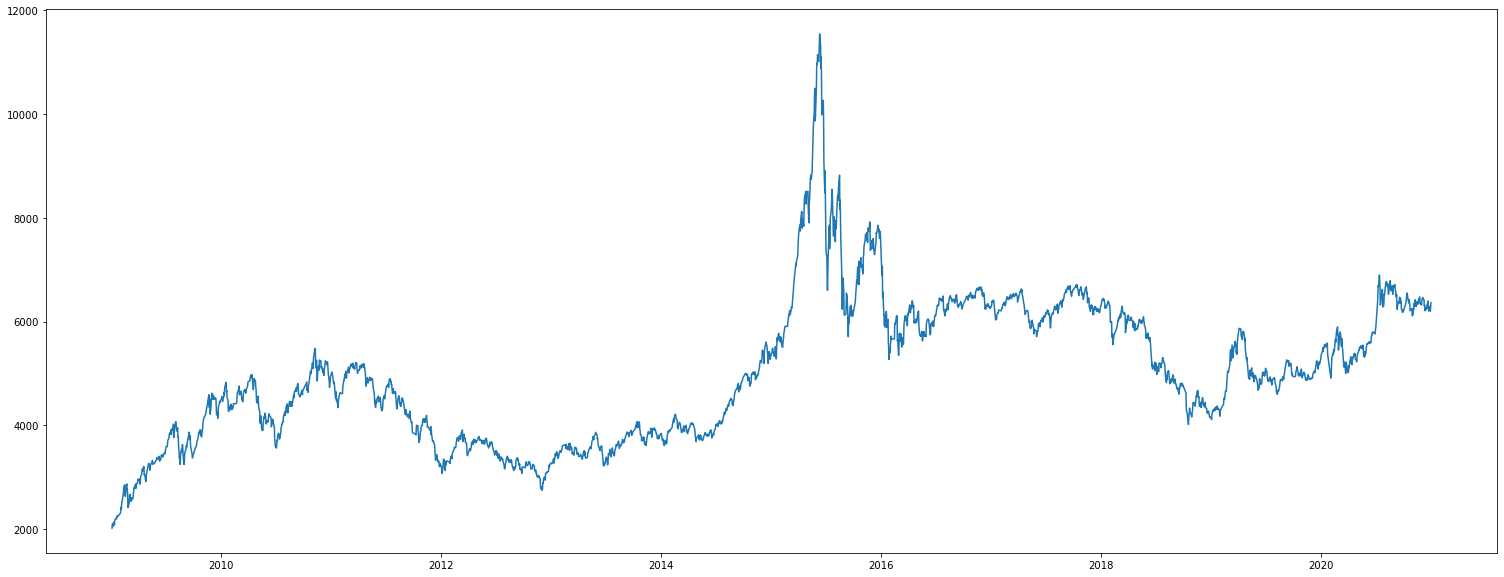

In [25]:
plt.figure(figsize=(26,10))
plt.plot(stockClosedf[stockClosedf.columns[stock_num]])

## 策略资金变化和股票仓位比关系

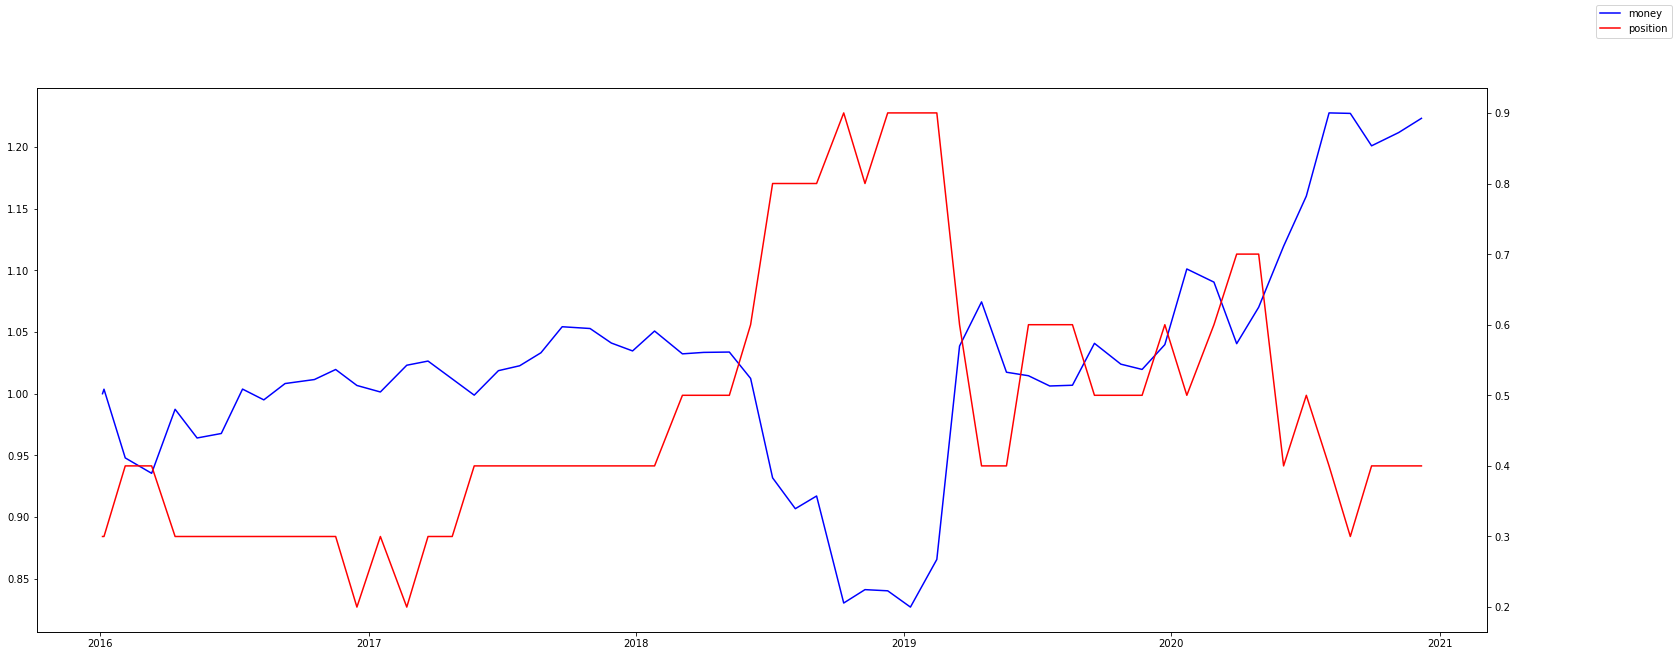

In [26]:
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,money_all,color = 'blue',label = 'money')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(150))
# ax1.grid()
ax2 = ax1.twinx() 
ax2.plot(time_all,position_all,color = 'red',label = 'position')
fig.legend()

## 收益率变化情况

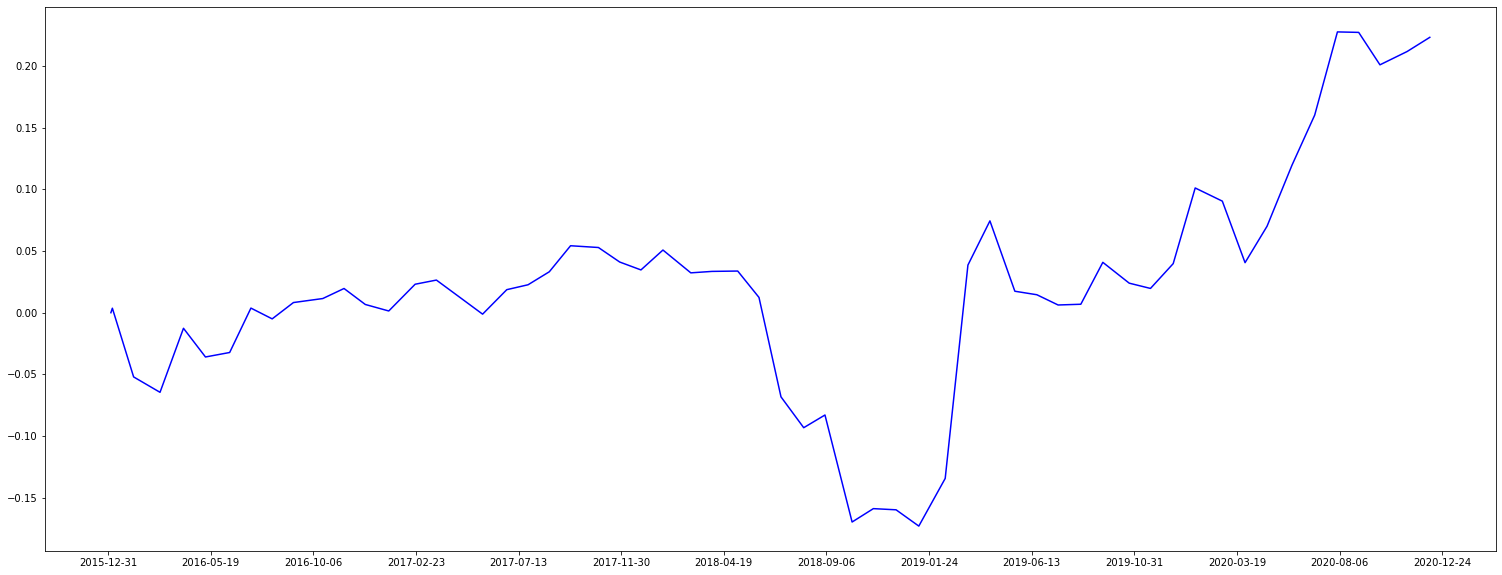

In [27]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,[i-1 for i in money_all],color = 'blue')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(140))
# ax1.grid()
# ax2 = ax1.twinx() 
# ax1.plot(time_all,[i-1 for i in money_all/money_all[0]],color = 'red')

## 策略最大回撤

In [28]:
max_drawdown = 0
max_drawdown_start = 0
max_drawdown_end = 0
for i in range(len(money_all)):
    for j in range(i+1,len(money_all)):
        if (money_all[i]-money_all[j])>max_drawdown:
            max_drawdown_start = i
            max_drawdown_end = j
            max_drawdown = money_all[i]-money_all[j]
print("策略最大回撤："+str(max_drawdown/money_all[max_drawdown_start])+"   时间："+str(time_all[max_drawdown_start]) + "("+str(np.around(money_all[max_drawdown_start],decimals =3))
      +") 至 "+str(time_all[max_drawdown_end])+ "("+str(np.around(money_all[max_drawdown_end],decimals =3))+")")

策略最大回撤：0.21559652089796733   时间：2017-09-22(1.054) 至 2019-01-10(0.827)


In [29]:
stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

资金   仓位     策略收益率  000905.SH     指数收益率
2016-01-04         1  0.3  0.000000  6983.4044  0.000000
2016-01-06  1.003642  0.3  0.003635  7065.6068  0.011702
2016-02-04  0.947936  0.4 -0.057104  5721.4853 -0.211010
2016-03-11  0.935457  0.4 -0.013252  5508.9818 -0.037849
2016-04-12  0.987381  0.3  0.054021  6252.7729  0.126645
2016-05-12    0.9641  0.3 -0.023861  5726.4555 -0.087928
2016-06-14  0.967739  0.3  0.003767  5762.7612  0.006320
2016-07-13  1.003736  0.3  0.036522  6446.5634  0.112130
2016-08-11     0.995  0.3 -0.008741  6226.3129 -0.034763
2016-09-09  1.008237  0.3  0.013215  6471.0530  0.038555
2016-10-19  1.011481  0.3  0.003213  6495.2574  0.003733
2016-11-17  1.019625  0.3  0.008018  6636.4690  0.021508
2016-12-16  1.006675  0.2 -0.012782  6318.5239 -0.049094
2017-01-17  1.001396  0.3 -0.005258  6082.0657 -0.038141
2017-02-22  1.023085  0.2  0.021427  6474.2250  0.062485
2017-03-23  1.026458  0.3  0.003292  6512.1874  0.005846
2017-04-25  1.011997  0.3 -0.014188  6160.4612 -0.055524
2017-05-25  0.998823  0.4 -0.013104  5850.8006 -0.051573
2017-06-27  1.018679  0.4  0.019685  6113.1658  0.043866
2017-07-26   1.02265  0.4  0.003891  6146.7028  0.005471
2017-08-24  1.033192  0.4  0.010255  6278.5900  0.021230
2017-09-22  1.054292  0.4  0.020216  6572.0096  0.045674
2017-10-30  1.052862  0.4 -0.001357  6511.7616 -0.009210
2017-11-28   1.04109  0.4 -0.011243  6299.3122 -0.033170
2017-12-27  1.034688  0.4 -0.006168  6173.1528 -0.020231
2018-01-26  1.050807  0.4  0.015458  6383.6312  0.033527
2018-03-05  1.032313  0.5 -0.017757  6064.0983 -0.051351
2018-04-03  1.033492  0.5  0.001142  6059.7089 -0.000724
2018-05-08  1.033774  0.5  0.000272  6041.8143 -0.002957
2018-06-06  1.012389  0.6 -0.020902  5774.2575 -0.045295
2018-07-06  0.931778  0.8 -0.082974  4996.6299 -0.144646
2018-08-06  0.906765  0.8 -0.027211  4825.2508 -0.034901
2018-09-04  0.917058  0.8  0.011288  4890.2806  0.013387
2018-10-11  0.830293  0.9 -0.099392  4307.4208 -0.126910
2018-11-09  0.841143  0.8  0.012983  4368.6143  0.014107
2018-12-10  0.840193  0.9 -0.001130  4359.3122 -0.002132
2019-01-10   0.82699  0.9 -0.015838  4281.8606 -0.017927
2019-02-15  0.865637  0.9  0.045673  4502.7348  0.050297
2019-03-18  1.038623  0.6  0.182185  5501.1830  0.200278
2019-04-17  1.074441  0.4  0.033905  5807.7288  0.054226
2019-05-21  1.017409  0.4 -0.054541  5009.8725 -0.147779
2019-06-20  1.014567  0.6 -0.002798  4954.7338 -0.011067
2019-07-19  1.006253  0.6 -0.008228  4878.6903 -0.015467
2019-08-19  1.006859  0.6  0.000602  4875.0363 -0.000749
2019-09-18  1.040834  0.5  0.033186  5141.0381  0.053127
2019-10-24  1.023948  0.5 -0.016356  4958.2465 -0.036203
2019-11-22  1.019678  0.5 -0.004179  4904.0828 -0.010984
2019-12-23  1.039797  0.6  0.019539  5084.3505  0.036099
2020-01-22   1.10113  0.5  0.057311  5575.5126  0.092217
2020-02-28  1.090453  0.6 -0.009743  5451.2897 -0.022532
2020-03-30  1.040573  0.7 -0.046822  5027.4856 -0.080932
2020-04-29  1.070107  0.7  0.027988  5226.8116  0.038881
2020-06-02   1.11958  0.4  0.045195  5566.4438  0.062955
2020-07-03  1.160224  0.5  0.035659  6051.5099  0.083551
2020-08-03  1.227663  0.4  0.056500  6739.8085  0.107724
2020-09-01  1.227274  0.3 -0.000317  6710.4599 -0.004364
2020-09-30  1.200979  0.4 -0.021658  6192.5045 -0.080328
2020-11-06  1.211746  0.4  0.008925  6301.2477  0.017408
2020-12-07  1.223263  0.4  0.009459  6424.6823  0.019400

## 策略表现
### 年化波动率计算：标准差*(N^0.5)

In [30]:
time_temp = ['2016年','2017年','2018年','2019年','2020年','五年总计'] 
return_temp = [money_all[12]/money_all[0]-1,money_all[24]/money_all[12]-1,money_all[35]/money_all[24]-1,money_all[47]/money_all[35]-1,money_all[-1]/money_all[47]-1,money_all[-1]/money_all[0]-1]
money_temp = [money_all[12],money_all[24],money_all[35],money_all[47],money_all[-1],money_all[-1]]
return_volatility = [info.iloc[:13].std()[2]*(13**0.5),info.iloc[13:25].std()[2]*(12**0.5),info.iloc[25:36].std()[2]*(11**0.5),
                     info.iloc[36:48].std()[2]*(12**0.5),info.iloc[48:].std()[2]*(11**0.5)]
return_volatility.append(sum([i/len(return_volatility) for i in return_volatility]))

index_temp = [stockClose.loc[info.index[12]],stockClose.loc[info.index[24]],stockClose.loc[info.index[35]],stockClose.loc[info.index[47]],stockClose.loc[info.index[-1]],stockClose.loc[info.index[-1]]]
index_return = [stockClose.loc[info.index[12]]/stockClose.loc[info.index[0]]-1,stockClose.loc[info.index[24]]/stockClose.loc[info.index[12]]-1,stockClose.loc[info.index[35]]/stockClose.loc[info.index[24]]-1,
               stockClose.loc[info.index[47]]/stockClose.loc[info.index[35]]-1,stockClose.loc[info.index[-1]]/stockClose.loc[info.index[47]]-1,stockClose.loc[info.index[-1]]/stockClose.loc[info.index[0]]-1]
index_return_volatility = [info.iloc[:13].std()[4]*(13**0.5),info.iloc[13:25].std()[4]*(12**0.5),info.iloc[25:36].std()[4]*(11**0.5),
                           info.iloc[36:48].std()[4]*(12**0.5),info.iloc[48:].std()[4]*(11**0.5)]
index_return_volatility.append(sum([i/len(index_return_volatility) for i in index_return_volatility]))

info_temp = pd.DataFrame([time_temp,money_temp,return_temp,return_volatility,index_temp,index_return,index_return_volatility], 
                         index=['时间','资金', '策略收益率','策略年化波动率','指数','指数收益率','指数年化波动率']).T.set_index(['时间'])
info_temp

资金     策略收益率   策略年化波动率         指数     指数收益率   指数年化波动率
时间                                                                
2016年  1.006675  0.006675  0.097478  6318.5239 -0.095209  0.307513
2017年  1.034688  0.027828  0.045415  6173.1528 -0.023007  0.136885
2018年  0.840193 -0.187975  0.127817  4359.3122 -0.293827  0.191816
2019年  1.039797   0.23757  0.202827  5084.3505  0.166319  0.279653
2020年  1.223263  0.176444  0.110495  6424.6823  0.263619  0.214419
五年总计   1.223263  0.223263  0.116807  6424.6823 -0.080007  0.226057